# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [1]:
# Project Imports
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
from lyrics2vec import lyrics2vec

# Python and Package Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import json
import time
import csv
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv('data/labeled_lyrics_expanded.csv', usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.575658
std,0.474571,0.493565,141.151970,19.502538,0.638805
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (63803, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 4  7 15  2  1  5 17 16 11  0 13 12  9  3  8  6 10 14]
(63803, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

3     And Oceans\nMiscellaneous\nNew Model World\n[i...
7     Electro eroticism\nIntelligence is sexy\nElect...
17    You fight just for the sake of it\nYou know wh...
19    I'm in the dark, I'd like to read his mind\nBu...
25    There was a time\nYou opened up every doorway\...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 63803


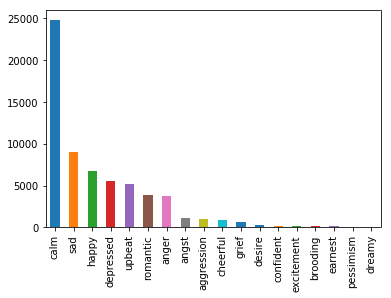

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

In [10]:
df.mood.value_counts()

calm          24733
sad            8986
happy          6689
depressed      5584
upbeat         5193
romantic       3849
anger          3809
angst          1085
aggression     1015
cheerful        946
grief           691
desire          267
confident       224
excitement      218
brooding        212
earnest         148
pessimism        85
dreamy           69
Name: mood, dtype: int64

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [11]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [12]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (38281, 9)
Dev: (12761, 9)
Test: (12761, 9)


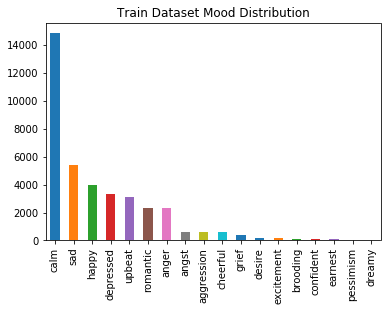

In [13]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

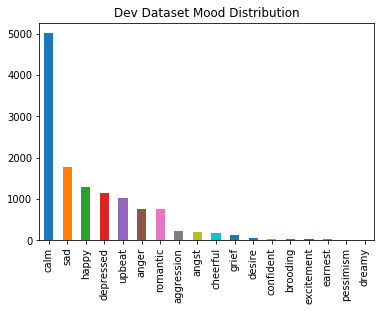

In [14]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

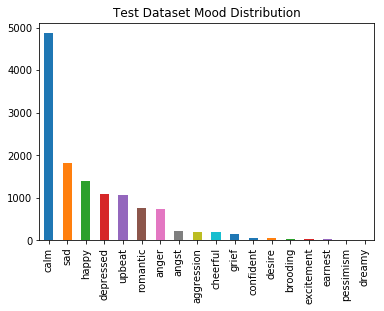

In [15]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [16]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [17]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: calm
	Dev: calm
	Test: calm
The accuracy of the most-common-case classifier for each dataset split is
	Train: 38.81%
	Dev: 39.26%
	Test: 38.15%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(38281, 62247)
(12761, 62247)
(12761, 62247)


In [19]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 39.43%
Naive Bayes Classifier Test Accuracy: 38.25%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [20]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 43.76%
SVM Classifier Test Accuracy: 42.89%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [21]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    63803.000000
mean       231.658982
std        139.035896
min          1.000000
25%        143.000000
50%        204.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [22]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

Provided words file path "logs/tf/lyrics2vec/vocabulary.txt" does not exist. Using logs/tf/lyrics2vec/vocabulary.txt instead.


TypeError: argument should be string, bytes or integer, not function

In [23]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

NameError: name 'lyrics_vectorizer' is not defined

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**

And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [129]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0,
      embeddings=None):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        # for loading word2vec: https://stackoverflow.com/questions/35687678/using-a-pre-trained-word-embedding-word2vec-or-glove-in-tensorflow
        with tf.device('/cpu:0'), tf.name_scope("embedding"):

            self.pretrained_embeddings = embeddings is not None
            if self.pretrained_embeddings:
                self.W = tf.get_variable(
                    shape=embeddings.shape,
                    initializer=tf.constant_initializer(embeddings),
                    trainable=True,
                    name="W")
            else:
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                Wconv = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="Wconv")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    Wconv,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            Wconv = tf.get_variable(
                "Wconv",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(Wconv)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, Wconv, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [130]:
# Parameters
# ==================================================

SAVE_STEP_DATA = True
USE_TIME_AS_KEY = False

# Model Hyperparameters
embedding_dim = 300
filter_sizes = [3,4,5]
num_filters = 64
dropout_keep_prob = 0.5
l2_reg_lambda = 0.01

# Training parameters
batch_size = 64
num_epochs = 20
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print('num_batches_per_epoch = {0}'.format(num_batches_per_epoch))
    for epoch in range(num_epochs):
        print('***********************************************')
        print('Epoch {0}/{1}\n'.format(epoch, num_epochs))
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            print('-----------------------------------------------')
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            print('Epoch {0}/{1}, Batch {2}/{3} (start={4}, end={5})'.format(
                epoch, num_epochs, batch_num, num_batches_per_epoch, start_index, end_index))
            yield shuffled_data[start_index:end_index]
            
def train(vocab_size, x_train, y_train, x_dev, y_dev, x_test, y_test, embeddings=None):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda,
                embeddings=embeddings)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            if USE_TIME_AS_KEY:
                unique_key = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            else:
                unique_key = 'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}_W2V-{7}-Tr_V-{8}'.format(
                    embedding_dim, '-'.join(map(str, filter_sizes)), num_filters, dropout_keep_prob,
                    l2_reg_lambda, batch_size, num_epochs, 1 if cnn.pretrained_embeddings else 0, vocab_size)
            out_dir = os.path.abspath(os.path.join(lyrics2vec.LOGS_TF_DIR, "runs", unique_key))
            os.makedirs(out_dir)
            print("Writing to {}\n".format(out_dir))
            
            # dump params to json in case they need to be referenced later
            with open(os.path.join(out_dir, 'model_params.json'), 'w') as outfile:
                model_params = {
                    'embedding_dim': embedding_dim,
                    'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'dropout_keep_prob': dropout_keep_prob,
                    'l2_reg_lambda': l2_reg_lambda,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'evaluate_every': evaluate_every,
                    'checkpoint_every': checkpoint_every,
                    'num_checkpoints': num_checkpoints,
                    'pretrained_embeddings': cnn.pretrained_embeddings
                }
                json.dump(model_params, outfile, sort_keys=True)
                
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            summary_dir = os.path.join(out_dir, "summaries")
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "train"), sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "dev"), sess.graph)

            # Test summaries
            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "test"), sess.graph)
            
            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy

            def dev_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy
                   
            csvwriter = None
            if SAVE_STEP_DATA:
                csvfile = open(os.path.join(out_dir, 'step_data.csv'), 'w')
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['dataset', 'time', 'step', 'loss', 'acc'])
                
            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch, summary_writer=train_summary_writer, step_writer=csvwriter)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, summary_writer=dev_summary_writer, step_writer=csvwriter)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                    
            print("\nFinal Test Evaluation:")
            dev_step(x_test, y_test, summary_writer=test_summary_writer, step_writer=csvwriter)


In [131]:
# get our pre-trained word2vec embeddings
lyrics_vectorizer = lyrics2vec.lyrics2vec()
embeddings_loaded = lyrics_vectorizer.load_embeddings()
if embeddings_loaded:
    print('embeddings shape:', lyrics_vectorizer.final_embeddings.shape)

embeddings shape: (50000, 300)


In [132]:
V = lyrics2vec.VOCAB_SIZE
#V = 50000
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train(
    vocab_size=V,
    x_train=np.array(list(df_train.normalized_lyrics)),
    y_train=pd.get_dummies(df_train.mood).values,
    x_dev=np.array(list(df_dev.normalized_lyrics)),
    y_dev=pd.get_dummies(df_dev.mood).values,
    x_test=np.array(list(df_test.normalized_lyrics)),
    y_test=pd.get_dummies(df_test.mood).values,
    embeddings=lyrics_vectorizer.final_embeddings
)

INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-max

2018-11-25T11:57:54.422613: step 39, loss 2.29976, acc 0.234375
-----------------------------------------------
Epoch 0/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T11:57:54.739234: step 40, loss 2.4349, acc 0.328125
-----------------------------------------------
Epoch 0/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T11:57:55.063624: step 41, loss 2.23206, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T11:57:55.387346: step 42, loss 2.23448, acc 0.15625
-----------------------------------------------
Epoch 0/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T11:57:55.714308: step 43, loss 2.42694, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 43/336 (start=2752, end=2816)
2018-11-25T11:57:56.048847: step 44, loss 2.17828, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 44/336 (start=2816, end=2880)
2018-11-25T11:57:56.393792: step 45, loss 2.2427

2018-11-25T11:58:11.523441: step 91, loss 2.1787, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T11:58:11.853291: step 92, loss 2.16307, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T11:58:12.197639: step 93, loss 2.23852, acc 0.203125
-----------------------------------------------
Epoch 0/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T11:58:12.532548: step 94, loss 2.12441, acc 0.359375
-----------------------------------------------
Epoch 0/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T11:58:12.855178: step 95, loss 2.19034, acc 0.21875
-----------------------------------------------
Epoch 0/20, Batch 95/336 (start=6080, end=6144)
2018-11-25T11:58:13.189194: step 96, loss 2.22868, acc 0.265625
-----------------------------------------------
Epoch 0/20, Batch 96/336 (start=6144, end=6208)
2018-11-25T11:58:13.514813: step 97, loss 2.482

2018-11-25T11:58:32.139285: step 141, loss 2.11946, acc 0.328125
-----------------------------------------------
Epoch 0/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T11:58:32.471824: step 142, loss 2.24465, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T11:58:32.811415: step 143, loss 2.28752, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T11:58:33.153320: step 144, loss 2.15032, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T11:58:33.487282: step 145, loss 2.02544, acc 0.4375
-----------------------------------------------
Epoch 0/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T11:58:33.827030: step 146, loss 2.16232, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 146/336 (start=9344, end=9408)
2018-11-25T11:58:34.152161: step 147, 

2018-11-25T11:58:48.947881: step 192, loss 2.04125, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T11:58:49.286307: step 193, loss 2.16719, acc 0.328125
-----------------------------------------------
Epoch 0/20, Batch 193/336 (start=12352, end=12416)
2018-11-25T11:58:49.619136: step 194, loss 2.08602, acc 0.375
-----------------------------------------------
Epoch 0/20, Batch 194/336 (start=12416, end=12480)
2018-11-25T11:58:49.951332: step 195, loss 2.11788, acc 0.203125
-----------------------------------------------
Epoch 0/20, Batch 195/336 (start=12480, end=12544)
2018-11-25T11:58:50.290373: step 196, loss 2.27744, acc 0.265625
-----------------------------------------------
Epoch 0/20, Batch 196/336 (start=12544, end=12608)
2018-11-25T11:58:50.634855: step 197, loss 2.08059, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 197/336 (start=12608, end=12672)
2018-11-25T11:58:50.946

2018-11-25T11:59:09.161334: step 241, loss 2.13252, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T11:59:09.484153: step 242, loss 1.86955, acc 0.484375
-----------------------------------------------
Epoch 0/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T11:59:09.822999: step 243, loss 1.98624, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 243/336 (start=15552, end=15616)
2018-11-25T11:59:10.153428: step 244, loss 2.06105, acc 0.28125
-----------------------------------------------
Epoch 0/20, Batch 244/336 (start=15616, end=15680)
2018-11-25T11:59:10.490059: step 245, loss 2.1417, acc 0.359375
-----------------------------------------------
Epoch 0/20, Batch 245/336 (start=15680, end=15744)
2018-11-25T11:59:10.827607: step 246, loss 2.26504, acc 0.34375
-----------------------------------------------
Epoch 0/20, Batch 246/336 (start=15744, end=15808)
2018-11-25T11:59:11.1424

2018-11-25T11:59:26.067560: step 292, loss 2.30668, acc 0.25
-----------------------------------------------
Epoch 0/20, Batch 292/336 (start=18688, end=18752)
2018-11-25T11:59:26.400240: step 293, loss 2.09425, acc 0.359375
-----------------------------------------------
Epoch 0/20, Batch 293/336 (start=18752, end=18816)
2018-11-25T11:59:26.740312: step 294, loss 1.85804, acc 0.3125
-----------------------------------------------
Epoch 0/20, Batch 294/336 (start=18816, end=18880)
2018-11-25T11:59:27.076032: step 295, loss 1.91149, acc 0.359375
-----------------------------------------------
Epoch 0/20, Batch 295/336 (start=18880, end=18944)
2018-11-25T11:59:27.405068: step 296, loss 2.23791, acc 0.390625
-----------------------------------------------
Epoch 0/20, Batch 296/336 (start=18944, end=19008)
2018-11-25T11:59:27.721542: step 297, loss 1.90085, acc 0.390625
-----------------------------------------------
Epoch 0/20, Batch 297/336 (start=19008, end=19072)
2018-11-25T11:59:28.02

2018-11-25T11:59:46.147338: step 341, loss 1.59004, acc 0.609375
-----------------------------------------------
Epoch 1/20, Batch 5/336 (start=320, end=384)
2018-11-25T11:59:46.488122: step 342, loss 1.61854, acc 0.578125
-----------------------------------------------
Epoch 1/20, Batch 6/336 (start=384, end=448)
2018-11-25T11:59:46.804356: step 343, loss 1.75861, acc 0.515625
-----------------------------------------------
Epoch 1/20, Batch 7/336 (start=448, end=512)
2018-11-25T11:59:47.145388: step 344, loss 1.89069, acc 0.453125
-----------------------------------------------
Epoch 1/20, Batch 8/336 (start=512, end=576)
2018-11-25T11:59:47.471441: step 345, loss 1.77402, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 9/336 (start=576, end=640)
2018-11-25T11:59:47.812652: step 346, loss 2.08454, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 10/336 (start=640, end=704)
2018-11-25T11:59:48.146025: step 347, loss 1.71355, acc

2018-11-25T12:00:03.373525: step 393, loss 1.73467, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 57/336 (start=3648, end=3712)
2018-11-25T12:00:03.706260: step 394, loss 1.62273, acc 0.484375
-----------------------------------------------
Epoch 1/20, Batch 58/336 (start=3712, end=3776)
2018-11-25T12:00:04.025189: step 395, loss 1.69646, acc 0.421875
-----------------------------------------------
Epoch 1/20, Batch 59/336 (start=3776, end=3840)
2018-11-25T12:00:04.357903: step 396, loss 1.88588, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 60/336 (start=3840, end=3904)
2018-11-25T12:00:04.694066: step 397, loss 1.87926, acc 0.375
-----------------------------------------------
Epoch 1/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T12:00:05.016687: step 398, loss 1.582, acc 0.578125
-----------------------------------------------
Epoch 1/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T12:00:05.330165: step 399, loss

2018-11-25T12:00:23.759876: step 443, loss 1.68729, acc 0.546875
-----------------------------------------------
Epoch 1/20, Batch 107/336 (start=6848, end=6912)
2018-11-25T12:00:24.084962: step 444, loss 1.58654, acc 0.5625
-----------------------------------------------
Epoch 1/20, Batch 108/336 (start=6912, end=6976)
2018-11-25T12:00:24.426408: step 445, loss 1.71459, acc 0.421875
-----------------------------------------------
Epoch 1/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T12:00:24.756265: step 446, loss 1.59052, acc 0.484375
-----------------------------------------------
Epoch 1/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T12:00:25.081485: step 447, loss 1.81764, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 111/336 (start=7104, end=7168)
2018-11-25T12:00:25.411179: step 448, loss 1.65757, acc 0.515625
-----------------------------------------------
Epoch 1/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T12:00:25.741918: ste

2018-11-25T12:00:40.617930: step 494, loss 1.74841, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T12:00:40.954203: step 495, loss 1.78605, acc 0.421875
-----------------------------------------------
Epoch 1/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T12:00:41.302867: step 496, loss 1.76031, acc 0.453125
-----------------------------------------------
Epoch 1/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T12:00:41.616089: step 497, loss 1.66973, acc 0.421875
-----------------------------------------------
Epoch 1/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T12:00:41.954548: step 498, loss 1.83886, acc 0.453125
-----------------------------------------------
Epoch 1/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T12:00:42.292348: step 499, loss 1.64861, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T12:00:4

2018-11-25T12:01:00.660229: step 543, loss 1.92505, acc 0.40625
-----------------------------------------------
Epoch 1/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T12:01:00.992472: step 544, loss 1.52835, acc 0.578125
-----------------------------------------------
Epoch 1/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T12:01:01.314424: step 545, loss 1.65643, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T12:01:01.652109: step 546, loss 1.67073, acc 0.484375
-----------------------------------------------
Epoch 1/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T12:01:01.989621: step 547, loss 1.97635, acc 0.421875
-----------------------------------------------
Epoch 1/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T12:01:02.326007: step 548, loss 1.5179, acc 0.578125
-----------------------------------------------
Epoch 1/20, Batch 212/336 (start=13568, end=13632)
2018-11-25T12:01:02

2018-11-25T12:01:17.522543: step 594, loss 1.79901, acc 0.515625
-----------------------------------------------
Epoch 1/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T12:01:17.850351: step 595, loss 1.68565, acc 0.453125
-----------------------------------------------
Epoch 1/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T12:01:18.188090: step 596, loss 1.72994, acc 0.46875
-----------------------------------------------
Epoch 1/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T12:01:18.518145: step 597, loss 1.52844, acc 0.484375
-----------------------------------------------
Epoch 1/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T12:01:18.845018: step 598, loss 1.86204, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 262/336 (start=16768, end=16832)
2018-11-25T12:01:19.167884: step 599, loss 1.63515, acc 0.53125
-----------------------------------------------
Epoch 1/20, Batch 263/336 (start=16832, end=16896)
2018-11-25T12:01:19.

2018-11-25T12:01:37.857563: step 643, loss 1.5625, acc 0.515625
-----------------------------------------------
Epoch 1/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T12:01:38.190293: step 644, loss 1.6728, acc 0.4375
-----------------------------------------------
Epoch 1/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T12:01:38.531566: step 645, loss 1.63808, acc 0.5
-----------------------------------------------
Epoch 1/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T12:01:38.854210: step 646, loss 1.83769, acc 0.359375
-----------------------------------------------
Epoch 1/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T12:01:39.181049: step 647, loss 1.66067, acc 0.5625
-----------------------------------------------
Epoch 1/20, Batch 311/336 (start=19904, end=19968)
2018-11-25T12:01:39.516379: step 648, loss 1.78535, acc 0.453125
-----------------------------------------------
Epoch 1/20, Batch 312/336 (start=19968, end=20032)
2018-11-25T12:01:39.861119:

2018-11-25T12:01:54.978535: step 694, loss 1.30375, acc 0.6875
-----------------------------------------------
Epoch 2/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T12:01:55.297591: step 695, loss 1.49437, acc 0.640625
-----------------------------------------------
Epoch 2/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T12:01:55.632865: step 696, loss 1.48826, acc 0.65625
-----------------------------------------------
Epoch 2/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T12:01:55.939820: step 697, loss 1.33681, acc 0.65625
-----------------------------------------------
Epoch 2/20, Batch 25/336 (start=1600, end=1664)
2018-11-25T12:01:56.280531: step 698, loss 1.37398, acc 0.65625
-----------------------------------------------
Epoch 2/20, Batch 26/336 (start=1664, end=1728)
2018-11-25T12:01:56.625063: step 699, loss 1.33893, acc 0.640625
-----------------------------------------------
Epoch 2/20, Batch 27/336 (start=1728, end=1792)
2018-11-25T12:01:56.965108: step 700, l

2018-11-25T12:02:15.649528: step 744, loss 1.30656, acc 0.734375
-----------------------------------------------
Epoch 2/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T12:02:15.958677: step 745, loss 1.39727, acc 0.640625
-----------------------------------------------
Epoch 2/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T12:02:16.291126: step 746, loss 1.50278, acc 0.625
-----------------------------------------------
Epoch 2/20, Batch 74/336 (start=4736, end=4800)
2018-11-25T12:02:16.626300: step 747, loss 1.40747, acc 0.578125
-----------------------------------------------
Epoch 2/20, Batch 75/336 (start=4800, end=4864)
2018-11-25T12:02:16.963658: step 748, loss 1.54543, acc 0.59375
-----------------------------------------------
Epoch 2/20, Batch 76/336 (start=4864, end=4928)
2018-11-25T12:02:17.281980: step 749, loss 1.30182, acc 0.671875
-----------------------------------------------
Epoch 2/20, Batch 77/336 (start=4928, end=4992)
2018-11-25T12:02:17.611762: step 750, 

2018-11-25T12:02:32.729514: step 796, loss 1.162, acc 0.65625
-----------------------------------------------
Epoch 2/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T12:02:33.060829: step 797, loss 1.43927, acc 0.609375
-----------------------------------------------
Epoch 2/20, Batch 125/336 (start=8000, end=8064)
2018-11-25T12:02:33.390393: step 798, loss 1.31516, acc 0.71875
-----------------------------------------------
Epoch 2/20, Batch 126/336 (start=8064, end=8128)
2018-11-25T12:02:33.727407: step 799, loss 1.3597, acc 0.625
-----------------------------------------------
Epoch 2/20, Batch 127/336 (start=8128, end=8192)
2018-11-25T12:02:34.070403: step 800, loss 1.17956, acc 0.640625

Evaluation:
2018-11-25T12:02:37.774389: step 800, loss 1.80245, acc 0.450258

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-800

-------------------------

2018-11-25T12:02:53.182881: step 845, loss 1.46418, acc 0.671875
-----------------------------------------------
Epoch 2/20, Batch 173/336 (start=11072, end=11136)
2018-11-25T12:02:53.518755: step 846, loss 1.2188, acc 0.671875
-----------------------------------------------
Epoch 2/20, Batch 174/336 (start=11136, end=11200)
2018-11-25T12:02:53.848865: step 847, loss 1.52193, acc 0.578125
-----------------------------------------------
Epoch 2/20, Batch 175/336 (start=11200, end=11264)
2018-11-25T12:02:54.186607: step 848, loss 1.32713, acc 0.625
-----------------------------------------------
Epoch 2/20, Batch 176/336 (start=11264, end=11328)
2018-11-25T12:02:54.519331: step 849, loss 1.39282, acc 0.53125
-----------------------------------------------
Epoch 2/20, Batch 177/336 (start=11328, end=11392)
2018-11-25T12:02:54.846342: step 850, loss 1.46441, acc 0.609375
-----------------------------------------------
Epoch 2/20, Batch 178/336 (start=11392, end=11456)
2018-11-25T12:02:55.1

2018-11-25T12:03:10.216326: step 896, loss 1.45504, acc 0.671875
-----------------------------------------------
Epoch 2/20, Batch 224/336 (start=14336, end=14400)
2018-11-25T12:03:10.544337: step 897, loss 1.44012, acc 0.640625
-----------------------------------------------
Epoch 2/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T12:03:10.875632: step 898, loss 1.14905, acc 0.625
-----------------------------------------------
Epoch 2/20, Batch 226/336 (start=14464, end=14528)
2018-11-25T12:03:11.188892: step 899, loss 1.37715, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 227/336 (start=14528, end=14592)
2018-11-25T12:03:11.509054: step 900, loss 1.06416, acc 0.75

Evaluation:
2018-11-25T12:03:15.041342: step 900, loss 1.79375, acc 0.457932

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-900

------------------

2018-11-25T12:03:30.315730: step 945, loss 1.37791, acc 0.609375
-----------------------------------------------
Epoch 2/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T12:03:30.656463: step 946, loss 1.39139, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 274/336 (start=17536, end=17600)
2018-11-25T12:03:30.985260: step 947, loss 1.24302, acc 0.625
-----------------------------------------------
Epoch 2/20, Batch 275/336 (start=17600, end=17664)
2018-11-25T12:03:31.319332: step 948, loss 1.60101, acc 0.546875
-----------------------------------------------
Epoch 2/20, Batch 276/336 (start=17664, end=17728)
2018-11-25T12:03:31.635983: step 949, loss 1.44201, acc 0.609375
-----------------------------------------------
Epoch 2/20, Batch 277/336 (start=17728, end=17792)
2018-11-25T12:03:31.971780: step 950, loss 1.48161, acc 0.59375
-----------------------------------------------
Epoch 2/20, Batch 278/336 (start=17792, end=17856)
2018-11-25T12:03:32.30

2018-11-25T12:03:47.331778: step 996, loss 1.35134, acc 0.6875
-----------------------------------------------
Epoch 2/20, Batch 324/336 (start=20736, end=20800)
2018-11-25T12:03:47.673416: step 997, loss 1.49448, acc 0.5625
-----------------------------------------------
Epoch 2/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T12:03:47.983581: step 998, loss 1.10682, acc 0.71875
-----------------------------------------------
Epoch 2/20, Batch 326/336 (start=20864, end=20928)
2018-11-25T12:03:48.352319: step 999, loss 1.12292, acc 0.703125
-----------------------------------------------
Epoch 2/20, Batch 327/336 (start=20928, end=20992)
2018-11-25T12:03:48.689232: step 1000, loss 1.30496, acc 0.65625

Evaluation:
2018-11-25T12:03:52.291718: step 1000, loss 1.77127, acc 0.470908

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-1000

------------

2018-11-25T12:04:07.614822: step 1045, loss 1.15827, acc 0.703125
-----------------------------------------------
Epoch 3/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T12:04:07.949144: step 1046, loss 1.04157, acc 0.703125
-----------------------------------------------
Epoch 3/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T12:04:08.278793: step 1047, loss 0.893724, acc 0.828125
-----------------------------------------------
Epoch 3/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T12:04:08.602376: step 1048, loss 1.30405, acc 0.640625
-----------------------------------------------
Epoch 3/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T12:04:08.937233: step 1049, loss 1.08459, acc 0.765625
-----------------------------------------------
Epoch 3/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T12:04:09.267238: step 1050, loss 1.24441, acc 0.6875
-----------------------------------------------
Epoch 3/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T12:04:09.596732: s

2018-11-25T12:04:24.475158: step 1096, loss 0.98891, acc 0.78125
-----------------------------------------------
Epoch 3/20, Batch 88/336 (start=5632, end=5696)
2018-11-25T12:04:24.823639: step 1097, loss 0.908062, acc 0.828125
-----------------------------------------------
Epoch 3/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T12:04:25.161171: step 1098, loss 1.06294, acc 0.75
-----------------------------------------------
Epoch 3/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T12:04:25.496145: step 1099, loss 0.954589, acc 0.796875
-----------------------------------------------
Epoch 3/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T12:04:25.827472: step 1100, loss 1.20383, acc 0.75

Evaluation:
2018-11-25T12:04:29.378164: step 1100, loss 1.76819, acc 0.471048

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-1100

---------------------

2018-11-25T12:04:44.736040: step 1145, loss 1.14483, acc 0.78125
-----------------------------------------------
Epoch 3/20, Batch 137/336 (start=8768, end=8832)
2018-11-25T12:04:45.063009: step 1146, loss 1.35267, acc 0.6875
-----------------------------------------------
Epoch 3/20, Batch 138/336 (start=8832, end=8896)
2018-11-25T12:04:45.408608: step 1147, loss 1.0445, acc 0.71875
-----------------------------------------------
Epoch 3/20, Batch 139/336 (start=8896, end=8960)
2018-11-25T12:04:45.744674: step 1148, loss 1.2634, acc 0.703125
-----------------------------------------------
Epoch 3/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T12:04:46.087358: step 1149, loss 1.1357, acc 0.75
-----------------------------------------------
Epoch 3/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T12:04:46.424806: step 1150, loss 0.825981, acc 0.890625
-----------------------------------------------
Epoch 3/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T12:04:46.763883: step

2018-11-25T12:05:01.691335: step 1196, loss 0.99963, acc 0.796875
-----------------------------------------------
Epoch 3/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T12:05:02.018975: step 1197, loss 1.07738, acc 0.6875
-----------------------------------------------
Epoch 3/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T12:05:02.348935: step 1198, loss 1.17056, acc 0.6875
-----------------------------------------------
Epoch 3/20, Batch 190/336 (start=12160, end=12224)
2018-11-25T12:05:02.659788: step 1199, loss 1.05568, acc 0.765625
-----------------------------------------------
Epoch 3/20, Batch 191/336 (start=12224, end=12288)
2018-11-25T12:05:02.991799: step 1200, loss 1.35539, acc 0.703125

Evaluation:
2018-11-25T12:05:06.539529: step 1200, loss 1.77936, acc 0.472722

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-1200

------

2018-11-25T12:05:21.992980: step 1245, loss 1.11547, acc 0.75
-----------------------------------------------
Epoch 3/20, Batch 237/336 (start=15168, end=15232)
2018-11-25T12:05:22.304413: step 1246, loss 1.16985, acc 0.71875
-----------------------------------------------
Epoch 3/20, Batch 238/336 (start=15232, end=15296)
2018-11-25T12:05:22.643290: step 1247, loss 1.12686, acc 0.65625
-----------------------------------------------
Epoch 3/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T12:05:22.976301: step 1248, loss 0.821503, acc 0.78125
-----------------------------------------------
Epoch 3/20, Batch 240/336 (start=15360, end=15424)
2018-11-25T12:05:23.320219: step 1249, loss 1.11121, acc 0.703125
-----------------------------------------------
Epoch 3/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T12:05:23.666203: step 1250, loss 1.14898, acc 0.796875
-----------------------------------------------
Epoch 3/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T12:05

2018-11-25T12:05:38.688202: step 1295, loss 1.33319, acc 0.625
-----------------------------------------------
Epoch 3/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T12:05:39.014640: step 1296, loss 1.1307, acc 0.734375
-----------------------------------------------
Epoch 3/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T12:05:39.365779: step 1297, loss 1.16326, acc 0.71875
-----------------------------------------------
Epoch 3/20, Batch 289/336 (start=18496, end=18560)
2018-11-25T12:05:39.698927: step 1298, loss 1.13973, acc 0.71875
-----------------------------------------------
Epoch 3/20, Batch 290/336 (start=18560, end=18624)
2018-11-25T12:05:40.036694: step 1299, loss 1.04299, acc 0.75
-----------------------------------------------
Epoch 3/20, Batch 291/336 (start=18624, end=18688)
2018-11-25T12:05:40.387919: step 1300, loss 1.0805, acc 0.734375

Evaluation:
2018-11-25T12:05:43.870934: step 1300, loss 1.77693, acc 0.479978

Saved model checkpoint to /home/jcworkma

2018-11-25T12:05:58.996776: step 1344, loss 1.13492, acc 0.737705
***********************************************
Epoch 4/20

-----------------------------------------------
Epoch 4/20, Batch 0/336 (start=0, end=64)
2018-11-25T12:05:59.326431: step 1345, loss 0.775796, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 1/336 (start=64, end=128)
2018-11-25T12:05:59.657964: step 1346, loss 1.00884, acc 0.8125
-----------------------------------------------
Epoch 4/20, Batch 2/336 (start=128, end=192)
2018-11-25T12:06:00.004436: step 1347, loss 0.827129, acc 0.796875
-----------------------------------------------
Epoch 4/20, Batch 3/336 (start=192, end=256)
2018-11-25T12:06:00.359755: step 1348, loss 0.928734, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 4/336 (start=256, end=320)
2018-11-25T12:06:00.698219: step 1349, loss 0.824582, acc 0.859375
-----------------------------------------------
Epoch 4/20, Batch 5/336 (start=320,

2018-11-25T12:06:15.956780: step 1395, loss 1.08793, acc 0.71875
-----------------------------------------------
Epoch 4/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T12:06:16.300453: step 1396, loss 0.768365, acc 0.890625
-----------------------------------------------
Epoch 4/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T12:06:16.643717: step 1397, loss 0.752979, acc 0.90625
-----------------------------------------------
Epoch 4/20, Batch 53/336 (start=3392, end=3456)
2018-11-25T12:06:16.982811: step 1398, loss 0.922838, acc 0.765625
-----------------------------------------------
Epoch 4/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T12:06:17.326341: step 1399, loss 0.78594, acc 0.859375
-----------------------------------------------
Epoch 4/20, Batch 55/336 (start=3520, end=3584)
2018-11-25T12:06:17.656809: step 1400, loss 0.896673, acc 0.828125

Evaluation:
2018-11-25T12:06:21.175177: step 1400, loss 1.79433, acc 0.473001

Saved model checkpoint to /home/jcworkma/j

2018-11-25T12:06:36.570401: step 1444, loss 0.83481, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 100/336 (start=6400, end=6464)
2018-11-25T12:06:36.903988: step 1445, loss 0.973483, acc 0.75
-----------------------------------------------
Epoch 4/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T12:06:37.245866: step 1446, loss 0.987631, acc 0.796875
-----------------------------------------------
Epoch 4/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T12:06:37.629299: step 1447, loss 0.725126, acc 0.875
-----------------------------------------------
Epoch 4/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T12:06:37.962914: step 1448, loss 0.878762, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T12:06:38.299228: step 1449, loss 0.705821, acc 0.9375
-----------------------------------------------
Epoch 4/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T12:06:38.631053

2018-11-25T12:06:53.645879: step 1495, loss 0.847036, acc 0.796875
-----------------------------------------------
Epoch 4/20, Batch 151/336 (start=9664, end=9728)
2018-11-25T12:06:53.965428: step 1496, loss 0.800319, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 152/336 (start=9728, end=9792)
2018-11-25T12:06:54.278617: step 1497, loss 0.810537, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T12:06:54.605517: step 1498, loss 0.752468, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T12:06:54.925749: step 1499, loss 0.778402, acc 0.890625
-----------------------------------------------
Epoch 4/20, Batch 155/336 (start=9920, end=9984)
2018-11-25T12:06:55.281203: step 1500, loss 0.989102, acc 0.734375

Evaluation:
2018-11-25T12:06:58.759221: step 1500, loss 1.80506, acc 0.469653

Saved model checkpoint to /home/jcw

2018-11-25T12:07:13.872194: step 1544, loss 0.941577, acc 0.78125
-----------------------------------------------
Epoch 4/20, Batch 200/336 (start=12800, end=12864)
2018-11-25T12:07:14.206050: step 1545, loss 0.93565, acc 0.8125
-----------------------------------------------
Epoch 4/20, Batch 201/336 (start=12864, end=12928)
2018-11-25T12:07:14.537910: step 1546, loss 0.677506, acc 0.90625
-----------------------------------------------
Epoch 4/20, Batch 202/336 (start=12928, end=12992)
2018-11-25T12:07:14.844878: step 1547, loss 0.862961, acc 0.8125
-----------------------------------------------
Epoch 4/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T12:07:15.188212: step 1548, loss 0.746012, acc 0.859375
-----------------------------------------------
Epoch 4/20, Batch 204/336 (start=13056, end=13120)
2018-11-25T12:07:15.529995: step 1549, loss 0.908822, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 205/336 (start=13120, end=13184)
2018-11-25T

2018-11-25T12:07:30.599803: step 1594, loss 0.639665, acc 0.890625
-----------------------------------------------
Epoch 4/20, Batch 250/336 (start=16000, end=16064)
2018-11-25T12:07:30.938984: step 1595, loss 0.964703, acc 0.78125
-----------------------------------------------
Epoch 4/20, Batch 251/336 (start=16064, end=16128)
2018-11-25T12:07:31.272276: step 1596, loss 0.776249, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 252/336 (start=16128, end=16192)
2018-11-25T12:07:31.604151: step 1597, loss 0.858737, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 253/336 (start=16192, end=16256)
2018-11-25T12:07:31.941355: step 1598, loss 0.816722, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 254/336 (start=16256, end=16320)
2018-11-25T12:07:32.256193: step 1599, loss 0.817373, acc 0.859375
-----------------------------------------------
Epoch 4/20, Batch 255/336 (start=16320, end=16384)
2018-1

2018-11-25T12:07:50.749846: step 1642, loss 0.91832, acc 0.78125
-----------------------------------------------
Epoch 4/20, Batch 298/336 (start=19072, end=19136)
2018-11-25T12:07:51.063841: step 1643, loss 1.01909, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 299/336 (start=19136, end=19200)
2018-11-25T12:07:51.403648: step 1644, loss 0.868919, acc 0.8125
-----------------------------------------------
Epoch 4/20, Batch 300/336 (start=19200, end=19264)
2018-11-25T12:07:51.750215: step 1645, loss 0.913952, acc 0.796875
-----------------------------------------------
Epoch 4/20, Batch 301/336 (start=19264, end=19328)
2018-11-25T12:07:52.083348: step 1646, loss 0.779587, acc 0.84375
-----------------------------------------------
Epoch 4/20, Batch 302/336 (start=19328, end=19392)
2018-11-25T12:07:52.414231: step 1647, loss 0.868747, acc 0.828125
-----------------------------------------------
Epoch 4/20, Batch 303/336 (start=19392, end=19456)
2018-11-25

2018-11-25T12:08:07.590516: step 1692, loss 0.780426, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 12/336 (start=768, end=832)
2018-11-25T12:08:07.920878: step 1693, loss 0.672545, acc 0.890625
-----------------------------------------------
Epoch 5/20, Batch 13/336 (start=832, end=896)
2018-11-25T12:08:08.252225: step 1694, loss 0.518216, acc 0.921875
-----------------------------------------------
Epoch 5/20, Batch 14/336 (start=896, end=960)
2018-11-25T12:08:08.574985: step 1695, loss 0.692487, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 15/336 (start=960, end=1024)
2018-11-25T12:08:08.907195: step 1696, loss 0.651159, acc 0.890625
-----------------------------------------------
Epoch 5/20, Batch 16/336 (start=1024, end=1088)
2018-11-25T12:08:09.241201: step 1697, loss 0.993258, acc 0.796875
-----------------------------------------------
Epoch 5/20, Batch 17/336 (start=1088, end=1152)
2018-11-25T12:08:09.576795: s

2018-11-25T12:08:27.793796: step 1741, loss 0.67513, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T12:08:28.125772: step 1742, loss 0.53401, acc 0.96875
-----------------------------------------------
Epoch 5/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T12:08:28.466801: step 1743, loss 0.570717, acc 0.921875
-----------------------------------------------
Epoch 5/20, Batch 63/336 (start=4032, end=4096)
2018-11-25T12:08:28.805630: step 1744, loss 0.551252, acc 0.921875
-----------------------------------------------
Epoch 5/20, Batch 64/336 (start=4096, end=4160)
2018-11-25T12:08:29.129823: step 1745, loss 0.73612, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 65/336 (start=4160, end=4224)
2018-11-25T12:08:29.465850: step 1746, loss 0.645633, acc 0.9375
-----------------------------------------------
Epoch 5/20, Batch 66/336 (start=4224, end=4288)
2018-11-25T12:08:29.795641: step 1

2018-11-25T12:08:44.895031: step 1792, loss 0.692231, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T12:08:45.223416: step 1793, loss 0.604407, acc 0.890625
-----------------------------------------------
Epoch 5/20, Batch 113/336 (start=7232, end=7296)
2018-11-25T12:08:45.553230: step 1794, loss 0.688758, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 114/336 (start=7296, end=7360)
2018-11-25T12:08:45.900036: step 1795, loss 0.946855, acc 0.8125
-----------------------------------------------
Epoch 5/20, Batch 115/336 (start=7360, end=7424)
2018-11-25T12:08:46.240162: step 1796, loss 0.726895, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 116/336 (start=7424, end=7488)
2018-11-25T12:08:46.577807: step 1797, loss 0.752093, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 117/336 (start=7488, end=7552)
2018-11-25T12:08:46.920770

2018-11-25T12:09:05.207005: step 1841, loss 0.586365, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T12:09:05.565348: step 1842, loss 0.877699, acc 0.796875
-----------------------------------------------
Epoch 5/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T12:09:05.906469: step 1843, loss 0.519334, acc 0.921875
-----------------------------------------------
Epoch 5/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T12:09:06.242839: step 1844, loss 0.793619, acc 0.828125
-----------------------------------------------
Epoch 5/20, Batch 164/336 (start=10496, end=10560)
2018-11-25T12:09:06.576912: step 1845, loss 0.7661, acc 0.8125
-----------------------------------------------
Epoch 5/20, Batch 165/336 (start=10560, end=10624)
2018-11-25T12:09:06.914087: step 1846, loss 0.68897, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 166/336 (start=10624, end=10688)
2018-11-25T1

2018-11-25T12:09:21.927363: step 1891, loss 0.652125, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T12:09:22.267940: step 1892, loss 0.694995, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 212/336 (start=13568, end=13632)
2018-11-25T12:09:22.610683: step 1893, loss 0.697753, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 213/336 (start=13632, end=13696)
2018-11-25T12:09:22.957537: step 1894, loss 0.859916, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 214/336 (start=13696, end=13760)
2018-11-25T12:09:23.298272: step 1895, loss 0.736802, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 215/336 (start=13760, end=13824)
2018-11-25T12:09:23.635256: step 1896, loss 0.691173, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 216/336 (start=13824, end=13888)
2018-11-2

2018-11-25T12:09:42.252984: step 1940, loss 0.660734, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T12:09:42.580081: step 1941, loss 0.705265, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T12:09:42.901161: step 1942, loss 0.767003, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 262/336 (start=16768, end=16832)
2018-11-25T12:09:43.242783: step 1943, loss 0.637937, acc 0.90625
-----------------------------------------------
Epoch 5/20, Batch 263/336 (start=16832, end=16896)
2018-11-25T12:09:43.589852: step 1944, loss 0.66877, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 264/336 (start=16896, end=16960)
2018-11-25T12:09:43.917211: step 1945, loss 0.744109, acc 0.8125
-----------------------------------------------
Epoch 5/20, Batch 265/336 (start=16960, end=17024)
2018-11-25T12

2018-11-25T12:09:59.052369: step 1990, loss 0.719731, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T12:09:59.375588: step 1991, loss 0.731363, acc 0.859375
-----------------------------------------------
Epoch 5/20, Batch 311/336 (start=19904, end=19968)
2018-11-25T12:09:59.711635: step 1992, loss 0.600008, acc 0.9375
-----------------------------------------------
Epoch 5/20, Batch 312/336 (start=19968, end=20032)
2018-11-25T12:10:00.053819: step 1993, loss 0.697841, acc 0.875
-----------------------------------------------
Epoch 5/20, Batch 313/336 (start=20032, end=20096)
2018-11-25T12:10:00.391656: step 1994, loss 0.777228, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 314/336 (start=20096, end=20160)
2018-11-25T12:10:00.704854: step 1995, loss 0.749543, acc 0.84375
-----------------------------------------------
Epoch 5/20, Batch 315/336 (start=20160, end=20224)
2018-11-25T12:

2018-11-25T12:10:19.458218: step 2039, loss 0.550419, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T12:10:19.800121: step 2040, loss 0.580603, acc 0.875
-----------------------------------------------
Epoch 6/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T12:10:20.137263: step 2041, loss 0.531031, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 25/336 (start=1600, end=1664)
2018-11-25T12:10:20.481072: step 2042, loss 0.59925, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 26/336 (start=1664, end=1728)
2018-11-25T12:10:20.830063: step 2043, loss 0.677337, acc 0.84375
-----------------------------------------------
Epoch 6/20, Batch 27/336 (start=1728, end=1792)
2018-11-25T12:10:21.171967: step 2044, loss 0.763276, acc 0.828125
-----------------------------------------------
Epoch 6/20, Batch 28/336 (start=1792, end=1856)
2018-11-25T12:10:21.510988: 

2018-11-25T12:10:36.647500: step 2090, loss 0.553443, acc 0.9375
-----------------------------------------------
Epoch 6/20, Batch 74/336 (start=4736, end=4800)
2018-11-25T12:10:36.975451: step 2091, loss 0.636456, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 75/336 (start=4800, end=4864)
2018-11-25T12:10:37.321430: step 2092, loss 0.718174, acc 0.828125
-----------------------------------------------
Epoch 6/20, Batch 76/336 (start=4864, end=4928)
2018-11-25T12:10:37.652275: step 2093, loss 0.728561, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 77/336 (start=4928, end=4992)
2018-11-25T12:10:37.986438: step 2094, loss 0.643566, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 78/336 (start=4992, end=5056)
2018-11-25T12:10:38.333072: step 2095, loss 0.513456, acc 0.9375
-----------------------------------------------
Epoch 6/20, Batch 79/336 (start=5056, end=5120)
2018-11-25T12:10:38.673734

2018-11-25T12:10:57.048591: step 2139, loss 0.395414, acc 0.96875
-----------------------------------------------
Epoch 6/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T12:10:57.381140: step 2140, loss 0.547323, acc 0.875
-----------------------------------------------
Epoch 6/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T12:10:57.730279: step 2141, loss 0.812956, acc 0.8125
-----------------------------------------------
Epoch 6/20, Batch 125/336 (start=8000, end=8064)
2018-11-25T12:10:58.074453: step 2142, loss 0.581561, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 126/336 (start=8064, end=8128)
2018-11-25T12:10:58.403034: step 2143, loss 0.47978, acc 0.9375
-----------------------------------------------
Epoch 6/20, Batch 127/336 (start=8128, end=8192)
2018-11-25T12:10:58.725557: step 2144, loss 0.538785, acc 0.921875
-----------------------------------------------
Epoch 6/20, Batch 128/336 (start=8192, end=8256)
2018-11-25T12:10:59.057236

2018-11-25T12:11:14.185366: step 2190, loss 0.594829, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 174/336 (start=11136, end=11200)
2018-11-25T12:11:14.533465: step 2191, loss 0.678343, acc 0.875
-----------------------------------------------
Epoch 6/20, Batch 175/336 (start=11200, end=11264)
2018-11-25T12:11:14.883131: step 2192, loss 0.692107, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 176/336 (start=11264, end=11328)
2018-11-25T12:11:15.220685: step 2193, loss 0.524176, acc 0.96875
-----------------------------------------------
Epoch 6/20, Batch 177/336 (start=11328, end=11392)
2018-11-25T12:11:15.557933: step 2194, loss 0.570958, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 178/336 (start=11392, end=11456)
2018-11-25T12:11:15.886243: step 2195, loss 0.572125, acc 0.9375
-----------------------------------------------
Epoch 6/20, Batch 179/336 (start=11456, end=11520)
2018-11-25T

2018-11-25T12:11:34.250594: step 2238, loss 0.523534, acc 0.921875
-----------------------------------------------
Epoch 6/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T12:11:34.585670: step 2239, loss 0.523788, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 223/336 (start=14272, end=14336)
2018-11-25T12:11:34.929245: step 2240, loss 0.61576, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 224/336 (start=14336, end=14400)
2018-11-25T12:11:35.278199: step 2241, loss 0.462966, acc 0.953125
-----------------------------------------------
Epoch 6/20, Batch 225/336 (start=14400, end=14464)
2018-11-25T12:11:35.610535: step 2242, loss 0.653181, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 226/336 (start=14464, end=14528)
2018-11-25T12:11:35.946755: step 2243, loss 0.749276, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 227/336 (start=14528, end=14592)
2018-

2018-11-25T12:11:51.111441: step 2288, loss 0.74404, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 272/336 (start=17408, end=17472)
2018-11-25T12:11:51.445034: step 2289, loss 0.634718, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 273/336 (start=17472, end=17536)
2018-11-25T12:11:51.785362: step 2290, loss 0.564887, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 274/336 (start=17536, end=17600)
2018-11-25T12:11:52.124519: step 2291, loss 0.757801, acc 0.8125
-----------------------------------------------
Epoch 6/20, Batch 275/336 (start=17600, end=17664)
2018-11-25T12:11:52.454163: step 2292, loss 0.573614, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 276/336 (start=17664, end=17728)
2018-11-25T12:11:52.793499: step 2293, loss 0.593565, acc 0.875
-----------------------------------------------
Epoch 6/20, Batch 277/336 (start=17728, end=17792)
2018-11-25T1

2018-11-25T12:12:11.455870: step 2337, loss 0.59863, acc 0.875
-----------------------------------------------
Epoch 6/20, Batch 321/336 (start=20544, end=20608)
2018-11-25T12:12:11.796594: step 2338, loss 0.657868, acc 0.90625
-----------------------------------------------
Epoch 6/20, Batch 322/336 (start=20608, end=20672)
2018-11-25T12:12:12.138527: step 2339, loss 0.647916, acc 0.890625
-----------------------------------------------
Epoch 6/20, Batch 323/336 (start=20672, end=20736)
2018-11-25T12:12:12.478719: step 2340, loss 0.571821, acc 0.921875
-----------------------------------------------
Epoch 6/20, Batch 324/336 (start=20736, end=20800)
2018-11-25T12:12:12.807136: step 2341, loss 0.659927, acc 0.859375
-----------------------------------------------
Epoch 6/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T12:12:13.112528: step 2342, loss 0.675944, acc 0.84375
-----------------------------------------------
Epoch 6/20, Batch 326/336 (start=20864, end=20928)
2018-11-25

2018-11-25T12:12:28.640689: step 2388, loss 0.550751, acc 0.890625
-----------------------------------------------
Epoch 7/20, Batch 36/336 (start=2304, end=2368)
2018-11-25T12:12:28.982850: step 2389, loss 0.784533, acc 0.84375
-----------------------------------------------
Epoch 7/20, Batch 37/336 (start=2368, end=2432)
2018-11-25T12:12:29.323845: step 2390, loss 0.472273, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 38/336 (start=2432, end=2496)
2018-11-25T12:12:29.662704: step 2391, loss 0.447668, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 39/336 (start=2496, end=2560)
2018-11-25T12:12:30.004067: step 2392, loss 0.461769, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T12:12:30.344755: step 2393, loss 0.679272, acc 0.859375
-----------------------------------------------
Epoch 7/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T12:12:30.688542:

2018-11-25T12:12:48.925373: step 2437, loss 0.478343, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T12:12:49.258210: step 2438, loss 0.571691, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 86/336 (start=5504, end=5568)
2018-11-25T12:12:49.599267: step 2439, loss 0.408191, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 87/336 (start=5568, end=5632)
2018-11-25T12:12:49.934206: step 2440, loss 0.486811, acc 0.953125
-----------------------------------------------
Epoch 7/20, Batch 88/336 (start=5632, end=5696)
2018-11-25T12:12:50.267932: step 2441, loss 0.510473, acc 0.90625
-----------------------------------------------
Epoch 7/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T12:12:50.596399: step 2442, loss 0.570586, acc 0.875
-----------------------------------------------
Epoch 7/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T12:12:50.933320: st

2018-11-25T12:13:06.109400: step 2488, loss 0.473241, acc 0.953125
-----------------------------------------------
Epoch 7/20, Batch 136/336 (start=8704, end=8768)
2018-11-25T12:13:06.448527: step 2489, loss 0.531905, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 137/336 (start=8768, end=8832)
2018-11-25T12:13:06.781783: step 2490, loss 0.60168, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 138/336 (start=8832, end=8896)
2018-11-25T12:13:07.100054: step 2491, loss 0.477554, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 139/336 (start=8896, end=8960)
2018-11-25T12:13:07.431497: step 2492, loss 0.603006, acc 0.90625
-----------------------------------------------
Epoch 7/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T12:13:07.771988: step 2493, loss 0.524507, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T12:13:08.11

2018-11-25T12:13:26.658932: step 2537, loss 0.582536, acc 0.90625
-----------------------------------------------
Epoch 7/20, Batch 185/336 (start=11840, end=11904)
2018-11-25T12:13:26.975468: step 2538, loss 0.484059, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 186/336 (start=11904, end=11968)
2018-11-25T12:13:27.313123: step 2539, loss 0.495697, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 187/336 (start=11968, end=12032)
2018-11-25T12:13:27.625278: step 2540, loss 0.435084, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T12:13:27.972581: step 2541, loss 0.621566, acc 0.890625
-----------------------------------------------
Epoch 7/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T12:13:28.304612: step 2542, loss 0.402057, acc 0.984375
-----------------------------------------------
Epoch 7/20, Batch 190/336 (start=12160, end=12224)
2018-11-2

2018-11-25T12:13:43.359571: step 2587, loss 0.487135, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 235/336 (start=15040, end=15104)
2018-11-25T12:13:43.700481: step 2588, loss 0.505065, acc 0.953125
-----------------------------------------------
Epoch 7/20, Batch 236/336 (start=15104, end=15168)
2018-11-25T12:13:44.035255: step 2589, loss 0.557103, acc 0.90625
-----------------------------------------------
Epoch 7/20, Batch 237/336 (start=15168, end=15232)
2018-11-25T12:13:44.369248: step 2590, loss 0.577788, acc 0.890625
-----------------------------------------------
Epoch 7/20, Batch 238/336 (start=15232, end=15296)
2018-11-25T12:13:44.712835: step 2591, loss 0.661952, acc 0.859375
-----------------------------------------------
Epoch 7/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T12:13:45.050856: step 2592, loss 0.419474, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 240/336 (start=15360, end=15424)
2018-

2018-11-25T12:14:03.478036: step 2635, loss 0.475337, acc 0.953125
-----------------------------------------------
Epoch 7/20, Batch 283/336 (start=18112, end=18176)
2018-11-25T12:14:03.795778: step 2636, loss 0.685806, acc 0.875
-----------------------------------------------
Epoch 7/20, Batch 284/336 (start=18176, end=18240)
2018-11-25T12:14:04.139027: step 2637, loss 0.749712, acc 0.859375
-----------------------------------------------
Epoch 7/20, Batch 285/336 (start=18240, end=18304)
2018-11-25T12:14:04.469999: step 2638, loss 0.517755, acc 0.921875
-----------------------------------------------
Epoch 7/20, Batch 286/336 (start=18304, end=18368)
2018-11-25T12:14:04.805187: step 2639, loss 0.3995, acc 0.96875
-----------------------------------------------
Epoch 7/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T12:14:05.126950: step 2640, loss 0.386358, acc 0.984375
-----------------------------------------------
Epoch 7/20, Batch 288/336 (start=18432, end=18496)
2018-11-25

2018-11-25T12:14:20.322378: step 2685, loss 0.487624, acc 0.9375
-----------------------------------------------
Epoch 7/20, Batch 333/336 (start=21312, end=21376)
2018-11-25T12:14:20.662830: step 2686, loss 0.727874, acc 0.890625
-----------------------------------------------
Epoch 7/20, Batch 334/336 (start=21376, end=21440)
2018-11-25T12:14:20.987079: step 2687, loss 0.5261, acc 0.90625
-----------------------------------------------
Epoch 7/20, Batch 335/336 (start=21440, end=21501)
2018-11-25T12:14:21.314673: step 2688, loss 0.6483, acc 0.918033
***********************************************
Epoch 8/20

-----------------------------------------------
Epoch 8/20, Batch 0/336 (start=0, end=64)
2018-11-25T12:14:21.657443: step 2689, loss 0.451191, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 1/336 (start=64, end=128)
2018-11-25T12:14:22.007145: step 2690, loss 0.600558, acc 0.875
-----------------------------------------------
Epoch 8/20, Batch 2/3

2018-11-25T12:14:40.820756: step 2734, loss 0.470604, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 46/336 (start=2944, end=3008)
2018-11-25T12:14:41.146339: step 2735, loss 0.422519, acc 0.9375
-----------------------------------------------
Epoch 8/20, Batch 47/336 (start=3008, end=3072)
2018-11-25T12:14:41.488986: step 2736, loss 0.472425, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 48/336 (start=3072, end=3136)
2018-11-25T12:14:41.835054: step 2737, loss 0.45524, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 49/336 (start=3136, end=3200)
2018-11-25T12:14:42.173976: step 2738, loss 0.685178, acc 0.828125
-----------------------------------------------
Epoch 8/20, Batch 50/336 (start=3200, end=3264)
2018-11-25T12:14:42.505974: step 2739, loss 0.446069, acc 0.9375
-----------------------------------------------
Epoch 8/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T12:14:42.848819:

2018-11-25T12:14:57.824375: step 2785, loss 0.565848, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 97/336 (start=6208, end=6272)
2018-11-25T12:14:58.164375: step 2786, loss 0.554484, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 98/336 (start=6272, end=6336)
2018-11-25T12:14:58.488876: step 2787, loss 0.55221, acc 0.859375
-----------------------------------------------
Epoch 8/20, Batch 99/336 (start=6336, end=6400)
2018-11-25T12:14:58.803475: step 2788, loss 0.48852, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 100/336 (start=6400, end=6464)
2018-11-25T12:14:59.137868: step 2789, loss 0.482559, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T12:14:59.475673: step 2790, loss 0.490413, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T12:14:59.8

2018-11-25T12:15:18.219371: step 2834, loss 0.513234, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 146/336 (start=9344, end=9408)
2018-11-25T12:15:18.563266: step 2835, loss 0.500543, acc 0.90625
-----------------------------------------------
Epoch 8/20, Batch 147/336 (start=9408, end=9472)
2018-11-25T12:15:18.910925: step 2836, loss 0.442383, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 148/336 (start=9472, end=9536)
2018-11-25T12:15:19.251749: step 2837, loss 0.346622, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 149/336 (start=9536, end=9600)
2018-11-25T12:15:19.577435: step 2838, loss 0.357372, acc 0.96875
-----------------------------------------------
Epoch 8/20, Batch 150/336 (start=9600, end=9664)
2018-11-25T12:15:19.919192: step 2839, loss 0.521361, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 151/336 (start=9664, end=9728)
2018-11-25T12:15:2

2018-11-25T12:15:34.893068: step 2884, loss 0.438787, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 196/336 (start=12544, end=12608)
2018-11-25T12:15:35.228608: step 2885, loss 0.585419, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 197/336 (start=12608, end=12672)
2018-11-25T12:15:35.570937: step 2886, loss 0.55323, acc 0.90625
-----------------------------------------------
Epoch 8/20, Batch 198/336 (start=12672, end=12736)
2018-11-25T12:15:35.909367: step 2887, loss 0.787079, acc 0.84375
-----------------------------------------------
Epoch 8/20, Batch 199/336 (start=12736, end=12800)
2018-11-25T12:15:36.252673: step 2888, loss 0.650967, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 200/336 (start=12800, end=12864)
2018-11-25T12:15:36.587380: step 2889, loss 0.390023, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 201/336 (start=12864, end=12928)
2018-11

2018-11-25T12:15:55.118118: step 2933, loss 0.351631, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 245/336 (start=15680, end=15744)
2018-11-25T12:15:55.460322: step 2934, loss 0.53024, acc 0.9375
-----------------------------------------------
Epoch 8/20, Batch 246/336 (start=15744, end=15808)
2018-11-25T12:15:55.793716: step 2935, loss 0.502498, acc 0.90625
-----------------------------------------------
Epoch 8/20, Batch 247/336 (start=15808, end=15872)
2018-11-25T12:15:56.145548: step 2936, loss 0.46453, acc 0.9375
-----------------------------------------------
Epoch 8/20, Batch 248/336 (start=15872, end=15936)
2018-11-25T12:15:56.474409: step 2937, loss 0.557699, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 249/336 (start=15936, end=16000)
2018-11-25T12:15:56.786171: step 2938, loss 0.523002, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 250/336 (start=16000, end=16064)
2018-11-25T

2018-11-25T12:16:11.824203: step 2983, loss 0.39279, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 295/336 (start=18880, end=18944)
2018-11-25T12:16:12.164211: step 2984, loss 0.422594, acc 0.953125
-----------------------------------------------
Epoch 8/20, Batch 296/336 (start=18944, end=19008)
2018-11-25T12:16:12.498779: step 2985, loss 0.405478, acc 0.96875
-----------------------------------------------
Epoch 8/20, Batch 297/336 (start=19008, end=19072)
2018-11-25T12:16:12.833881: step 2986, loss 0.541203, acc 0.890625
-----------------------------------------------
Epoch 8/20, Batch 298/336 (start=19072, end=19136)
2018-11-25T12:16:13.153260: step 2987, loss 0.577006, acc 0.90625
-----------------------------------------------
Epoch 8/20, Batch 299/336 (start=19136, end=19200)
2018-11-25T12:16:13.469515: step 2988, loss 0.558032, acc 0.921875
-----------------------------------------------
Epoch 8/20, Batch 300/336 (start=19200, end=19264)
2018-11

2018-11-25T12:16:31.788453: step 3031, loss 0.410844, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 7/336 (start=448, end=512)
2018-11-25T12:16:32.137237: step 3032, loss 0.52527, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 8/336 (start=512, end=576)
2018-11-25T12:16:32.486618: step 3033, loss 0.560744, acc 0.875
-----------------------------------------------
Epoch 9/20, Batch 9/336 (start=576, end=640)
2018-11-25T12:16:32.820322: step 3034, loss 0.418183, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 10/336 (start=640, end=704)
2018-11-25T12:16:33.164606: step 3035, loss 0.42708, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 11/336 (start=704, end=768)
2018-11-25T12:16:33.503976: step 3036, loss 0.411183, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 12/336 (start=768, end=832)
2018-11-25T12:16:33.833024: step 3037, loss 0.

2018-11-25T12:16:48.914415: step 3082, loss 0.441814, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 58/336 (start=3712, end=3776)
2018-11-25T12:16:49.249562: step 3083, loss 0.453613, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 59/336 (start=3776, end=3840)
2018-11-25T12:16:49.582269: step 3084, loss 0.436802, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 60/336 (start=3840, end=3904)
2018-11-25T12:16:49.922498: step 3085, loss 0.440768, acc 0.96875
-----------------------------------------------
Epoch 9/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T12:16:50.263828: step 3086, loss 0.55787, acc 0.875
-----------------------------------------------
Epoch 9/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T12:16:50.579269: step 3087, loss 0.40221, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 63/336 (start=4032, end=4096)
2018-11-25T12:16:50.914621: 

2018-11-25T12:17:09.175263: step 3131, loss 0.646368, acc 0.875
-----------------------------------------------
Epoch 9/20, Batch 107/336 (start=6848, end=6912)
2018-11-25T12:17:09.513555: step 3132, loss 0.363778, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 108/336 (start=6912, end=6976)
2018-11-25T12:17:09.849110: step 3133, loss 0.343635, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T12:17:10.195070: step 3134, loss 0.520555, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T12:17:10.553681: step 3135, loss 0.468439, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 111/336 (start=7104, end=7168)
2018-11-25T12:17:10.860360: step 3136, loss 0.390197, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T12:17:11.1

2018-11-25T12:17:26.249149: step 3182, loss 0.442659, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 158/336 (start=10112, end=10176)
2018-11-25T12:17:26.571370: step 3183, loss 0.376981, acc 0.984375
-----------------------------------------------
Epoch 9/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T12:17:26.908440: step 3184, loss 0.632746, acc 0.8125
-----------------------------------------------
Epoch 9/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T12:17:27.254251: step 3185, loss 0.463636, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T12:17:27.589394: step 3186, loss 0.451512, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T12:17:27.908288: step 3187, loss 0.398072, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 163/336 (start=10432, end=10496)
2018-11-25

2018-11-25T12:17:46.540875: step 3231, loss 0.468034, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T12:17:46.881497: step 3232, loss 0.474733, acc 0.890625
-----------------------------------------------
Epoch 9/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T12:17:47.210236: step 3233, loss 0.399578, acc 0.984375
-----------------------------------------------
Epoch 9/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T12:17:47.545819: step 3234, loss 0.376274, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T12:17:47.892183: step 3235, loss 0.467569, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T12:17:48.228280: step 3236, loss 0.440839, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 212/336 (start=13568, end=13632)
2018-11

2018-11-25T12:18:03.439368: step 3281, loss 0.409755, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T12:18:03.781324: step 3282, loss 0.546004, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T12:18:04.094544: step 3283, loss 0.434216, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T12:18:04.439289: step 3284, loss 0.476597, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T12:18:04.786890: step 3285, loss 0.542181, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T12:18:05.110726: step 3286, loss 0.365881, acc 0.984375
-----------------------------------------------
Epoch 9/20, Batch 262/336 (start=16768, end=16832)
2018-11-25

2018-11-25T12:18:23.372132: step 3329, loss 0.47708, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T12:18:23.704171: step 3330, loss 0.445372, acc 0.921875
-----------------------------------------------
Epoch 9/20, Batch 306/336 (start=19584, end=19648)
2018-11-25T12:18:24.034687: step 3331, loss 0.535295, acc 0.9375
-----------------------------------------------
Epoch 9/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T12:18:24.375264: step 3332, loss 0.549694, acc 0.875
-----------------------------------------------
Epoch 9/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T12:18:24.706426: step 3333, loss 0.481797, acc 0.90625
-----------------------------------------------
Epoch 9/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T12:18:25.034333: step 3334, loss 0.410808, acc 0.953125
-----------------------------------------------
Epoch 9/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T1

2018-11-25T12:18:40.025644: step 3379, loss 0.409732, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 19/336 (start=1216, end=1280)
2018-11-25T12:18:40.353092: step 3380, loss 0.377837, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 20/336 (start=1280, end=1344)
2018-11-25T12:18:40.688674: step 3381, loss 0.316226, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T12:18:41.025986: step 3382, loss 0.309146, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T12:18:41.363174: step 3383, loss 0.411189, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T12:18:41.705797: step 3384, loss 0.373865, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T12:18:42.0

2018-11-25T12:19:00.324901: step 3428, loss 0.342672, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 68/336 (start=4352, end=4416)
2018-11-25T12:19:00.650846: step 3429, loss 0.483155, acc 0.90625
-----------------------------------------------
Epoch 10/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T12:19:00.972294: step 3430, loss 0.459974, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T12:19:01.303801: step 3431, loss 0.485316, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T12:19:01.643271: step 3432, loss 0.422428, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T12:19:01.981104: step 3433, loss 0.434162, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T12:19:02.29

2018-11-25T12:19:17.254896: step 3479, loss 0.406628, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 119/336 (start=7616, end=7680)
2018-11-25T12:19:17.573794: step 3480, loss 0.395042, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 120/336 (start=7680, end=7744)
2018-11-25T12:19:17.913561: step 3481, loss 0.38371, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 121/336 (start=7744, end=7808)
2018-11-25T12:19:18.236794: step 3482, loss 0.541978, acc 0.875
-----------------------------------------------
Epoch 10/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T12:19:18.569370: step 3483, loss 0.441006, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T12:19:18.889435: step 3484, loss 0.3857, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T12:19:19

2018-11-25T12:19:37.495136: step 3528, loss 0.441792, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 168/336 (start=10752, end=10816)
2018-11-25T12:19:37.826064: step 3529, loss 0.354027, acc 0.984375
-----------------------------------------------
Epoch 10/20, Batch 169/336 (start=10816, end=10880)
2018-11-25T12:19:38.166486: step 3530, loss 0.38994, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 170/336 (start=10880, end=10944)
2018-11-25T12:19:38.512173: step 3531, loss 0.585763, acc 0.84375
-----------------------------------------------
Epoch 10/20, Batch 171/336 (start=10944, end=11008)
2018-11-25T12:19:38.853315: step 3532, loss 0.406003, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T12:19:39.190973: step 3533, loss 0.35631, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 173/336 (start=11072, end=11136)
2018-

2018-11-25T12:19:54.283215: step 3578, loss 0.217756, acc 1
-----------------------------------------------
Epoch 10/20, Batch 218/336 (start=13952, end=14016)
2018-11-25T12:19:54.612825: step 3579, loss 0.328995, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 219/336 (start=14016, end=14080)
2018-11-25T12:19:54.958427: step 3580, loss 0.589375, acc 0.828125
-----------------------------------------------
Epoch 10/20, Batch 220/336 (start=14080, end=14144)
2018-11-25T12:19:55.302767: step 3581, loss 0.334789, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 221/336 (start=14144, end=14208)
2018-11-25T12:19:55.627064: step 3582, loss 0.64194, acc 0.90625
-----------------------------------------------
Epoch 10/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T12:19:55.978216: step 3583, loss 0.392019, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 223/336 (start=14272, end=14336)
2018-11-

2018-11-25T12:20:14.391741: step 3626, loss 0.285172, acc 0.984375
-----------------------------------------------
Epoch 10/20, Batch 266/336 (start=17024, end=17088)
2018-11-25T12:20:14.718680: step 3627, loss 0.546458, acc 0.90625
-----------------------------------------------
Epoch 10/20, Batch 267/336 (start=17088, end=17152)
2018-11-25T12:20:15.032768: step 3628, loss 0.559933, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 268/336 (start=17152, end=17216)
2018-11-25T12:20:15.375162: step 3629, loss 0.564827, acc 0.90625
-----------------------------------------------
Epoch 10/20, Batch 269/336 (start=17216, end=17280)
2018-11-25T12:20:15.698430: step 3630, loss 0.314971, acc 0.984375
-----------------------------------------------
Epoch 10/20, Batch 270/336 (start=17280, end=17344)
2018-11-25T12:20:16.040281: step 3631, loss 0.350078, acc 0.96875
-----------------------------------------------
Epoch 10/20, Batch 271/336 (start=17344, end=17408)
2

2018-11-25T12:20:31.139082: step 3676, loss 0.423253, acc 0.921875
-----------------------------------------------
Epoch 10/20, Batch 316/336 (start=20224, end=20288)
2018-11-25T12:20:31.470117: step 3677, loss 0.405493, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 317/336 (start=20288, end=20352)
2018-11-25T12:20:31.817091: step 3678, loss 0.433497, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 318/336 (start=20352, end=20416)
2018-11-25T12:20:32.152791: step 3679, loss 0.300926, acc 0.984375
-----------------------------------------------
Epoch 10/20, Batch 319/336 (start=20416, end=20480)
2018-11-25T12:20:32.497777: step 3680, loss 0.332117, acc 0.9375
-----------------------------------------------
Epoch 10/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T12:20:32.819639: step 3681, loss 0.456365, acc 0.953125
-----------------------------------------------
Epoch 10/20, Batch 321/336 (start=20544, end=20608)
20

2018-11-25T12:20:51.380409: step 3725, loss 0.329866, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 29/336 (start=1856, end=1920)
2018-11-25T12:20:51.695538: step 3726, loss 0.385106, acc 0.9375
-----------------------------------------------
Epoch 11/20, Batch 30/336 (start=1920, end=1984)
2018-11-25T12:20:52.038654: step 3727, loss 0.434011, acc 0.9375
-----------------------------------------------
Epoch 11/20, Batch 31/336 (start=1984, end=2048)
2018-11-25T12:20:52.378608: step 3728, loss 0.348394, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 32/336 (start=2048, end=2112)
2018-11-25T12:20:52.708748: step 3729, loss 0.400625, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T12:20:53.051902: step 3730, loss 0.311988, acc 0.9375
-----------------------------------------------
Epoch 11/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T12:20:53.37

2018-11-25T12:21:08.496871: step 3776, loss 0.318427, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 80/336 (start=5120, end=5184)
2018-11-25T12:21:08.843934: step 3777, loss 0.279938, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 81/336 (start=5184, end=5248)
2018-11-25T12:21:09.184494: step 3778, loss 0.258986, acc 1
-----------------------------------------------
Epoch 11/20, Batch 82/336 (start=5248, end=5312)
2018-11-25T12:21:09.505905: step 3779, loss 0.393823, acc 0.921875
-----------------------------------------------
Epoch 11/20, Batch 83/336 (start=5312, end=5376)
2018-11-25T12:21:09.827293: step 3780, loss 0.387098, acc 0.9375
-----------------------------------------------
Epoch 11/20, Batch 84/336 (start=5376, end=5440)
2018-11-25T12:21:10.166923: step 3781, loss 0.337633, acc 0.984375
-----------------------------------------------
Epoch 11/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T12:21:10.486161:

2018-11-25T12:21:28.753748: step 3825, loss 0.367053, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 129/336 (start=8256, end=8320)
2018-11-25T12:21:29.080588: step 3826, loss 0.380421, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 130/336 (start=8320, end=8384)
2018-11-25T12:21:29.425030: step 3827, loss 0.34732, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 131/336 (start=8384, end=8448)
2018-11-25T12:21:29.757563: step 3828, loss 0.436483, acc 0.921875
-----------------------------------------------
Epoch 11/20, Batch 132/336 (start=8448, end=8512)
2018-11-25T12:21:30.100900: step 3829, loss 0.480912, acc 0.921875
-----------------------------------------------
Epoch 11/20, Batch 133/336 (start=8512, end=8576)
2018-11-25T12:21:30.431149: step 3830, loss 0.304709, acc 0.984375
-----------------------------------------------
Epoch 11/20, Batch 134/336 (start=8576, end=8640)
2018-11-25T1

2018-11-25T12:21:45.467151: step 3875, loss 0.350284, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 179/336 (start=11456, end=11520)
2018-11-25T12:21:45.790708: step 3876, loss 0.517164, acc 0.890625
-----------------------------------------------
Epoch 11/20, Batch 180/336 (start=11520, end=11584)
2018-11-25T12:21:46.118631: step 3877, loss 0.418079, acc 0.921875
-----------------------------------------------
Epoch 11/20, Batch 181/336 (start=11584, end=11648)
2018-11-25T12:21:46.451399: step 3878, loss 0.332543, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 182/336 (start=11648, end=11712)
2018-11-25T12:21:46.759375: step 3879, loss 0.576419, acc 0.875
-----------------------------------------------
Epoch 11/20, Batch 183/336 (start=11712, end=11776)
2018-11-25T12:21:47.097966: step 3880, loss 0.256144, acc 0.984375
-----------------------------------------------
Epoch 11/20, Batch 184/336 (start=11776, end=11840)
201

2018-11-25T12:22:05.281026: step 3923, loss 0.493074, acc 0.921875
-----------------------------------------------
Epoch 11/20, Batch 227/336 (start=14528, end=14592)
2018-11-25T12:22:05.620485: step 3924, loss 0.324753, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 228/336 (start=14592, end=14656)
2018-11-25T12:22:05.948056: step 3925, loss 0.265491, acc 1
-----------------------------------------------
Epoch 11/20, Batch 229/336 (start=14656, end=14720)
2018-11-25T12:22:06.290158: step 3926, loss 0.316265, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 230/336 (start=14720, end=14784)
2018-11-25T12:22:06.625860: step 3927, loss 0.371107, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 231/336 (start=14784, end=14848)
2018-11-25T12:22:06.934753: step 3928, loss 0.481395, acc 0.90625
-----------------------------------------------
Epoch 11/20, Batch 232/336 (start=14848, end=14912)
2018-11

2018-11-25T12:22:21.858090: step 3973, loss 0.397286, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 277/336 (start=17728, end=17792)
2018-11-25T12:22:22.207679: step 3974, loss 0.377469, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 278/336 (start=17792, end=17856)
2018-11-25T12:22:22.540570: step 3975, loss 0.34407, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 279/336 (start=17856, end=17920)
2018-11-25T12:22:22.869853: step 3976, loss 0.271493, acc 1
-----------------------------------------------
Epoch 11/20, Batch 280/336 (start=17920, end=17984)
2018-11-25T12:22:23.206625: step 3977, loss 0.296571, acc 0.984375
-----------------------------------------------
Epoch 11/20, Batch 281/336 (start=17984, end=18048)
2018-11-25T12:22:23.528107: step 3978, loss 0.318139, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 282/336 (start=18048, end=18112)
2018-11

2018-11-25T12:22:41.722220: step 4021, loss 0.434962, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T12:22:42.037593: step 4022, loss 0.354563, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 326/336 (start=20864, end=20928)
2018-11-25T12:22:42.376187: step 4023, loss 0.300508, acc 0.96875
-----------------------------------------------
Epoch 11/20, Batch 327/336 (start=20928, end=20992)
2018-11-25T12:22:42.722216: step 4024, loss 0.385771, acc 0.9375
-----------------------------------------------
Epoch 11/20, Batch 328/336 (start=20992, end=21056)
2018-11-25T12:22:43.056630: step 4025, loss 0.43285, acc 0.953125
-----------------------------------------------
Epoch 11/20, Batch 329/336 (start=21056, end=21120)
2018-11-25T12:22:43.419728: step 4026, loss 0.40577, acc 0.984375
-----------------------------------------------
Epoch 11/20, Batch 330/336 (start=21120, end=21184)
201

2018-11-25T12:22:58.727120: step 4072, loss 0.337829, acc 0.984375
-----------------------------------------------
Epoch 12/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T12:22:59.035177: step 4073, loss 0.363398, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T12:22:59.377896: step 4074, loss 0.283317, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T12:22:59.718938: step 4075, loss 0.452468, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 43/336 (start=2752, end=2816)
2018-11-25T12:23:00.039176: step 4076, loss 0.412189, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 44/336 (start=2816, end=2880)
2018-11-25T12:23:00.398139: step 4077, loss 0.25041, acc 0.984375
-----------------------------------------------
Epoch 12/20, Batch 45/336 (start=2880, end=2944)
2018-11-25T12:23:00.725

2018-11-25T12:23:19.159996: step 4121, loss 0.328981, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T12:23:19.486649: step 4122, loss 0.286293, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T12:23:19.831543: step 4123, loss 0.298614, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T12:23:20.168266: step 4124, loss 0.288918, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T12:23:20.505684: step 4125, loss 0.494182, acc 0.90625
-----------------------------------------------
Epoch 12/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T12:23:20.850783: step 4126, loss 0.28337, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T12:23:21.16

2018-11-25T12:23:36.132910: step 4172, loss 0.357414, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T12:23:36.475384: step 4173, loss 0.281135, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T12:23:36.813784: step 4174, loss 0.362096, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T12:23:37.157287: step 4175, loss 0.366053, acc 0.921875
-----------------------------------------------
Epoch 12/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T12:23:37.485726: step 4176, loss 0.318363, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T12:23:37.823983: step 4177, loss 0.298909, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T12:2

2018-11-25T12:23:56.244398: step 4220, loss 0.363482, acc 0.921875
-----------------------------------------------
Epoch 12/20, Batch 188/336 (start=12032, end=12096)
2018-11-25T12:23:56.557430: step 4221, loss 0.34009, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T12:23:56.892999: step 4222, loss 0.393452, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 190/336 (start=12160, end=12224)
2018-11-25T12:23:57.232313: step 4223, loss 0.358268, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 191/336 (start=12224, end=12288)
2018-11-25T12:23:57.545732: step 4224, loss 0.369396, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T12:23:57.875845: step 4225, loss 0.448773, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 193/336 (start=12352, end=12416)
2018-

2018-11-25T12:24:13.038011: step 4270, loss 0.388671, acc 0.921875
-----------------------------------------------
Epoch 12/20, Batch 238/336 (start=15232, end=15296)
2018-11-25T12:24:13.373676: step 4271, loss 0.438906, acc 0.90625
-----------------------------------------------
Epoch 12/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T12:24:13.710746: step 4272, loss 0.359221, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 240/336 (start=15360, end=15424)
2018-11-25T12:24:14.058761: step 4273, loss 0.341491, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T12:24:14.395777: step 4274, loss 0.406704, acc 0.921875
-----------------------------------------------
Epoch 12/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T12:24:14.710877: step 4275, loss 0.298825, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 243/336 (start=15552, end=15616)
20

2018-11-25T12:24:33.010296: step 4318, loss 0.320582, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 286/336 (start=18304, end=18368)
2018-11-25T12:24:33.355165: step 4319, loss 0.531694, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 287/336 (start=18368, end=18432)
2018-11-25T12:24:33.686580: step 4320, loss 0.338981, acc 0.96875
-----------------------------------------------
Epoch 12/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T12:24:34.015314: step 4321, loss 0.352583, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 289/336 (start=18496, end=18560)
2018-11-25T12:24:34.357646: step 4322, loss 0.379724, acc 0.9375
-----------------------------------------------
Epoch 12/20, Batch 290/336 (start=18560, end=18624)
2018-11-25T12:24:34.696343: step 4323, loss 0.323011, acc 0.953125
-----------------------------------------------
Epoch 12/20, Batch 291/336 (start=18624, end=18688)
2018-11

2018-11-25T12:24:49.705824: step 4368, loss 0.265862, acc 0.967213
***********************************************
Epoch 13/20

-----------------------------------------------
Epoch 13/20, Batch 0/336 (start=0, end=64)
2018-11-25T12:24:50.037404: step 4369, loss 0.242959, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 1/336 (start=64, end=128)
2018-11-25T12:24:50.380379: step 4370, loss 0.234181, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 2/336 (start=128, end=192)
2018-11-25T12:24:50.713927: step 4371, loss 0.350172, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 3/336 (start=192, end=256)
2018-11-25T12:24:51.036642: step 4372, loss 0.2626, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 4/336 (start=256, end=320)
2018-11-25T12:24:51.376257: step 4373, loss 0.269821, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 5/336 (

2018-11-25T12:25:10.099879: step 4417, loss 0.304756, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 49/336 (start=3136, end=3200)
2018-11-25T12:25:10.440861: step 4418, loss 0.243114, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 50/336 (start=3200, end=3264)
2018-11-25T12:25:10.788994: step 4419, loss 0.279047, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 51/336 (start=3264, end=3328)
2018-11-25T12:25:11.126230: step 4420, loss 0.216866, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T12:25:11.445149: step 4421, loss 0.367897, acc 0.921875
-----------------------------------------------
Epoch 13/20, Batch 53/336 (start=3392, end=3456)
2018-11-25T12:25:11.782463: step 4422, loss 0.418041, acc 0.921875
-----------------------------------------------
Epoch 13/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T12:25:

2018-11-25T12:25:27.132239: step 4468, loss 0.36467, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 100/336 (start=6400, end=6464)
2018-11-25T12:25:27.454988: step 4469, loss 0.247778, acc 1
-----------------------------------------------
Epoch 13/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T12:25:27.787368: step 4470, loss 0.295665, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T12:25:28.121448: step 4471, loss 0.392105, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T12:25:28.458395: step 4472, loss 0.37625, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T12:25:28.788507: step 4473, loss 0.238776, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T12:25:29.1173

2018-11-25T12:25:47.485641: step 4517, loss 0.325841, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 149/336 (start=9536, end=9600)
2018-11-25T12:25:47.821645: step 4518, loss 0.334198, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 150/336 (start=9600, end=9664)
2018-11-25T12:25:48.144806: step 4519, loss 0.282787, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 151/336 (start=9664, end=9728)
2018-11-25T12:25:48.467108: step 4520, loss 0.447334, acc 0.921875
-----------------------------------------------
Epoch 13/20, Batch 152/336 (start=9728, end=9792)
2018-11-25T12:25:48.791884: step 4521, loss 0.258974, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T12:25:49.133286: step 4522, loss 0.271265, acc 1
-----------------------------------------------
Epoch 13/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T12:25:49.

2018-11-25T12:26:04.104799: step 4567, loss 0.289514, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 199/336 (start=12736, end=12800)
2018-11-25T12:26:04.425552: step 4568, loss 0.398315, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 200/336 (start=12800, end=12864)
2018-11-25T12:26:04.771591: step 4569, loss 0.358146, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 201/336 (start=12864, end=12928)
2018-11-25T12:26:05.087815: step 4570, loss 0.398427, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 202/336 (start=12928, end=12992)
2018-11-25T12:26:05.406382: step 4571, loss 0.267339, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T12:26:05.752710: step 4572, loss 0.299417, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 204/336 (start=13056, end=13120)
2018

2018-11-25T12:26:23.975550: step 4615, loss 0.325669, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 247/336 (start=15808, end=15872)
2018-11-25T12:26:24.316502: step 4616, loss 0.345831, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 248/336 (start=15872, end=15936)
2018-11-25T12:26:24.653142: step 4617, loss 0.583381, acc 0.875
-----------------------------------------------
Epoch 13/20, Batch 249/336 (start=15936, end=16000)
2018-11-25T12:26:24.992405: step 4618, loss 0.273172, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 250/336 (start=16000, end=16064)
2018-11-25T12:26:25.334438: step 4619, loss 0.307001, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 251/336 (start=16064, end=16128)
2018-11-25T12:26:25.668376: step 4620, loss 0.230289, acc 0.984375
-----------------------------------------------
Epoch 13/20, Batch 252/336 (start=16128, end=16192)
2018

2018-11-25T12:26:40.815814: step 4665, loss 0.262415, acc 0.96875
-----------------------------------------------
Epoch 13/20, Batch 297/336 (start=19008, end=19072)
2018-11-25T12:26:41.155227: step 4666, loss 0.449759, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 298/336 (start=19072, end=19136)
2018-11-25T12:26:41.466928: step 4667, loss 0.331955, acc 0.953125
-----------------------------------------------
Epoch 13/20, Batch 299/336 (start=19136, end=19200)
2018-11-25T12:26:41.802622: step 4668, loss 0.339898, acc 0.921875
-----------------------------------------------
Epoch 13/20, Batch 300/336 (start=19200, end=19264)
2018-11-25T12:26:42.134713: step 4669, loss 0.380001, acc 0.921875
-----------------------------------------------
Epoch 13/20, Batch 301/336 (start=19264, end=19328)
2018-11-25T12:26:42.465075: step 4670, loss 0.381359, acc 0.9375
-----------------------------------------------
Epoch 13/20, Batch 302/336 (start=19328, end=19392)
201

2018-11-25T12:27:00.757380: step 4713, loss 0.218873, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 9/336 (start=576, end=640)
2018-11-25T12:27:01.093162: step 4714, loss 0.208863, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 10/336 (start=640, end=704)
2018-11-25T12:27:01.433069: step 4715, loss 0.379052, acc 0.921875
-----------------------------------------------
Epoch 14/20, Batch 11/336 (start=704, end=768)
2018-11-25T12:27:01.767457: step 4716, loss 0.322088, acc 0.9375
-----------------------------------------------
Epoch 14/20, Batch 12/336 (start=768, end=832)
2018-11-25T12:27:02.110525: step 4717, loss 0.196294, acc 1
-----------------------------------------------
Epoch 14/20, Batch 13/336 (start=832, end=896)
2018-11-25T12:27:02.450423: step 4718, loss 0.25035, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 14/336 (start=896, end=960)
2018-11-25T12:27:02.780284: step 4719, l

2018-11-25T12:27:17.775988: step 4764, loss 0.286852, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 60/336 (start=3840, end=3904)
2018-11-25T12:27:18.097644: step 4765, loss 0.326664, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T12:27:18.429746: step 4766, loss 0.415378, acc 0.921875
-----------------------------------------------
Epoch 14/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T12:27:18.767891: step 4767, loss 0.232619, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 63/336 (start=4032, end=4096)
2018-11-25T12:27:19.106303: step 4768, loss 0.256158, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 64/336 (start=4096, end=4160)
2018-11-25T12:27:19.443755: step 4769, loss 0.284394, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 65/336 (start=4160, end=4224)
2018-11-25T12:27:19

2018-11-25T12:27:38.047589: step 4813, loss 0.315295, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 109/336 (start=6976, end=7040)
2018-11-25T12:27:38.372629: step 4814, loss 0.230675, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 110/336 (start=7040, end=7104)
2018-11-25T12:27:38.695725: step 4815, loss 0.498952, acc 0.890625
-----------------------------------------------
Epoch 14/20, Batch 111/336 (start=7104, end=7168)
2018-11-25T12:27:39.027722: step 4816, loss 0.313861, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T12:27:39.364793: step 4817, loss 0.210042, acc 1
-----------------------------------------------
Epoch 14/20, Batch 113/336 (start=7232, end=7296)
2018-11-25T12:27:39.708073: step 4818, loss 0.318295, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 114/336 (start=7296, end=7360)
2018-11-25T12:27:40

2018-11-25T12:27:54.730207: step 4863, loss 0.339259, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 159/336 (start=10176, end=10240)
2018-11-25T12:27:55.063718: step 4864, loss 0.376786, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 160/336 (start=10240, end=10304)
2018-11-25T12:27:55.413119: step 4865, loss 0.310456, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T12:27:55.745912: step 4866, loss 0.365864, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T12:27:56.080414: step 4867, loss 0.243254, acc 1
-----------------------------------------------
Epoch 14/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T12:27:56.416153: step 4868, loss 0.35746, acc 0.890625
-----------------------------------------------
Epoch 14/20, Batch 164/336 (start=10496, end=10560)
2018-11-

2018-11-25T12:28:14.876345: step 4911, loss 0.368831, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 207/336 (start=13248, end=13312)
2018-11-25T12:28:15.214475: step 4912, loss 0.290987, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 208/336 (start=13312, end=13376)
2018-11-25T12:28:15.552373: step 4913, loss 0.349975, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 209/336 (start=13376, end=13440)
2018-11-25T12:28:15.895249: step 4914, loss 0.304309, acc 0.9375
-----------------------------------------------
Epoch 14/20, Batch 210/336 (start=13440, end=13504)
2018-11-25T12:28:16.232072: step 4915, loss 0.343365, acc 0.9375
-----------------------------------------------
Epoch 14/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T12:28:16.565098: step 4916, loss 0.268617, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 212/336 (start=13568, end=13632)
2018

2018-11-25T12:28:31.644361: step 4961, loss 0.393462, acc 0.921875
-----------------------------------------------
Epoch 14/20, Batch 257/336 (start=16448, end=16512)
2018-11-25T12:28:31.978025: step 4962, loss 0.296107, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 258/336 (start=16512, end=16576)
2018-11-25T12:28:32.303859: step 4963, loss 0.301909, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T12:28:32.646318: step 4964, loss 0.329622, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T12:28:32.975909: step 4965, loss 0.351304, acc 0.9375
-----------------------------------------------
Epoch 14/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T12:28:33.310353: step 4966, loss 0.245632, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 262/336 (start=16768, end=16832)
201

2018-11-25T12:28:51.647117: step 5009, loss 0.238425, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 305/336 (start=19520, end=19584)
2018-11-25T12:28:51.991640: step 5010, loss 0.273136, acc 0.96875
-----------------------------------------------
Epoch 14/20, Batch 306/336 (start=19584, end=19648)
2018-11-25T12:28:52.326316: step 5011, loss 0.282158, acc 0.984375
-----------------------------------------------
Epoch 14/20, Batch 307/336 (start=19648, end=19712)
2018-11-25T12:28:52.663950: step 5012, loss 0.478928, acc 0.9375
-----------------------------------------------
Epoch 14/20, Batch 308/336 (start=19712, end=19776)
2018-11-25T12:28:52.998885: step 5013, loss 0.17996, acc 1
-----------------------------------------------
Epoch 14/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T12:28:53.341749: step 5014, loss 0.285645, acc 0.953125
-----------------------------------------------
Epoch 14/20, Batch 310/336 (start=19840, end=19904)
2018-11-2

2018-11-25T12:29:08.469682: step 5059, loss 0.197481, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 19/336 (start=1216, end=1280)
2018-11-25T12:29:08.811312: step 5060, loss 0.305756, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 20/336 (start=1280, end=1344)
2018-11-25T12:29:09.126984: step 5061, loss 0.196214, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 21/336 (start=1344, end=1408)
2018-11-25T12:29:09.461506: step 5062, loss 0.307548, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 22/336 (start=1408, end=1472)
2018-11-25T12:29:09.793979: step 5063, loss 0.326294, acc 0.921875
-----------------------------------------------
Epoch 15/20, Batch 23/336 (start=1472, end=1536)
2018-11-25T12:29:10.138622: step 5064, loss 0.223095, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 24/336 (start=1536, end=1600)
2018-11-25T12:29:10.

2018-11-25T12:29:28.993133: step 5108, loss 0.380494, acc 0.921875
-----------------------------------------------
Epoch 15/20, Batch 68/336 (start=4352, end=4416)
2018-11-25T12:29:29.311773: step 5109, loss 0.19327, acc 1
-----------------------------------------------
Epoch 15/20, Batch 69/336 (start=4416, end=4480)
2018-11-25T12:29:29.652745: step 5110, loss 0.332578, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 70/336 (start=4480, end=4544)
2018-11-25T12:29:29.996307: step 5111, loss 0.384177, acc 0.953125
-----------------------------------------------
Epoch 15/20, Batch 71/336 (start=4544, end=4608)
2018-11-25T12:29:30.339936: step 5112, loss 0.225951, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 72/336 (start=4608, end=4672)
2018-11-25T12:29:30.670468: step 5113, loss 0.301957, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 73/336 (start=4672, end=4736)
2018-11-25T12:29:31.025841: 

2018-11-25T12:29:46.139821: step 5159, loss 0.333292, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 119/336 (start=7616, end=7680)
2018-11-25T12:29:46.474216: step 5160, loss 0.27125, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 120/336 (start=7680, end=7744)
2018-11-25T12:29:46.817896: step 5161, loss 0.254376, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 121/336 (start=7744, end=7808)
2018-11-25T12:29:47.148874: step 5162, loss 0.274992, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 122/336 (start=7808, end=7872)
2018-11-25T12:29:47.459812: step 5163, loss 0.344911, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 123/336 (start=7872, end=7936)
2018-11-25T12:29:47.798577: step 5164, loss 0.278731, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 124/336 (start=7936, end=8000)
2018-11-25T12:29:48

2018-11-25T12:30:06.477548: step 5208, loss 0.253619, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 168/336 (start=10752, end=10816)
2018-11-25T12:30:06.820659: step 5209, loss 0.240521, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 169/336 (start=10816, end=10880)
2018-11-25T12:30:07.151063: step 5210, loss 0.246837, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 170/336 (start=10880, end=10944)
2018-11-25T12:30:07.497203: step 5211, loss 0.265142, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 171/336 (start=10944, end=11008)
2018-11-25T12:30:07.851350: step 5212, loss 0.180515, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 172/336 (start=11008, end=11072)
2018-11-25T12:30:08.190280: step 5213, loss 0.249973, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 173/336 (start=11072, end=11136)


2018-11-25T12:30:23.301017: step 5258, loss 0.256966, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 218/336 (start=13952, end=14016)
2018-11-25T12:30:23.631563: step 5259, loss 0.235995, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 219/336 (start=14016, end=14080)
2018-11-25T12:30:23.971448: step 5260, loss 0.301135, acc 0.921875
-----------------------------------------------
Epoch 15/20, Batch 220/336 (start=14080, end=14144)
2018-11-25T12:30:24.320233: step 5261, loss 0.264901, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 221/336 (start=14144, end=14208)
2018-11-25T12:30:24.660289: step 5262, loss 0.311307, acc 0.953125
-----------------------------------------------
Epoch 15/20, Batch 222/336 (start=14208, end=14272)
2018-11-25T12:30:24.994829: step 5263, loss 0.292479, acc 0.9375
-----------------------------------------------
Epoch 15/20, Batch 223/336 (start=14272, end=14336)
2

2018-11-25T12:30:43.356410: step 5306, loss 0.251503, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 266/336 (start=17024, end=17088)
2018-11-25T12:30:43.689762: step 5307, loss 0.266016, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 267/336 (start=17088, end=17152)
2018-11-25T12:30:44.017699: step 5308, loss 0.290153, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 268/336 (start=17152, end=17216)
2018-11-25T12:30:44.352846: step 5309, loss 0.169902, acc 1
-----------------------------------------------
Epoch 15/20, Batch 269/336 (start=17216, end=17280)
2018-11-25T12:30:44.694115: step 5310, loss 0.313435, acc 0.921875
-----------------------------------------------
Epoch 15/20, Batch 270/336 (start=17280, end=17344)
2018-11-25T12:30:45.016276: step 5311, loss 0.237186, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 271/336 (start=17344, end=17408)
2018-1

2018-11-25T12:31:00.032255: step 5356, loss 0.290232, acc 0.953125
-----------------------------------------------
Epoch 15/20, Batch 316/336 (start=20224, end=20288)
2018-11-25T12:31:00.376106: step 5357, loss 0.278893, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 317/336 (start=20288, end=20352)
2018-11-25T12:31:00.689801: step 5358, loss 0.332037, acc 0.953125
-----------------------------------------------
Epoch 15/20, Batch 318/336 (start=20352, end=20416)
2018-11-25T12:31:01.030703: step 5359, loss 0.251875, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 319/336 (start=20416, end=20480)
2018-11-25T12:31:01.368016: step 5360, loss 0.270997, acc 0.984375
-----------------------------------------------
Epoch 15/20, Batch 320/336 (start=20480, end=20544)
2018-11-25T12:31:01.695143: step 5361, loss 0.292968, acc 0.96875
-----------------------------------------------
Epoch 15/20, Batch 321/336 (start=20544, end=20608)
2

2018-11-25T12:31:20.367355: step 5405, loss 0.185807, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 29/336 (start=1856, end=1920)
2018-11-25T12:31:20.702255: step 5406, loss 0.330671, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 30/336 (start=1920, end=1984)
2018-11-25T12:31:21.036408: step 5407, loss 0.205118, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 31/336 (start=1984, end=2048)
2018-11-25T12:31:21.375858: step 5408, loss 0.353423, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 32/336 (start=2048, end=2112)
2018-11-25T12:31:21.714258: step 5409, loss 0.234315, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 33/336 (start=2112, end=2176)
2018-11-25T12:31:22.035396: step 5410, loss 0.250983, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 34/336 (start=2176, end=2240)
2018-11-25T12:31:

2018-11-25T12:31:37.536499: step 5456, loss 0.215417, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 80/336 (start=5120, end=5184)
2018-11-25T12:31:37.865827: step 5457, loss 0.193668, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 81/336 (start=5184, end=5248)
2018-11-25T12:31:38.203176: step 5458, loss 0.286763, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 82/336 (start=5248, end=5312)
2018-11-25T12:31:38.535561: step 5459, loss 0.219402, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 83/336 (start=5312, end=5376)
2018-11-25T12:31:38.882433: step 5460, loss 0.31035, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 84/336 (start=5376, end=5440)
2018-11-25T12:31:39.228585: step 5461, loss 0.317606, acc 0.9375
-----------------------------------------------
Epoch 16/20, Batch 85/336 (start=5440, end=5504)
2018-11-25T12:31:39.

2018-11-25T12:31:57.878666: step 5505, loss 0.229258, acc 1
-----------------------------------------------
Epoch 16/20, Batch 129/336 (start=8256, end=8320)
2018-11-25T12:31:58.213801: step 5506, loss 0.22908, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 130/336 (start=8320, end=8384)
2018-11-25T12:31:58.549935: step 5507, loss 0.215305, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 131/336 (start=8384, end=8448)
2018-11-25T12:31:58.873394: step 5508, loss 0.189877, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 132/336 (start=8448, end=8512)
2018-11-25T12:31:59.213549: step 5509, loss 0.379665, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 133/336 (start=8512, end=8576)
2018-11-25T12:31:59.560074: step 5510, loss 0.178819, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 134/336 (start=8576, end=8640)
2018-11-25T12:31:59

2018-11-25T12:32:14.715231: step 5555, loss 0.222622, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 179/336 (start=11456, end=11520)
2018-11-25T12:32:15.060411: step 5556, loss 0.203651, acc 1
-----------------------------------------------
Epoch 16/20, Batch 180/336 (start=11520, end=11584)
2018-11-25T12:32:15.399317: step 5557, loss 0.241566, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 181/336 (start=11584, end=11648)
2018-11-25T12:32:15.735848: step 5558, loss 0.242102, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 182/336 (start=11648, end=11712)
2018-11-25T12:32:16.073716: step 5559, loss 0.233621, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 183/336 (start=11712, end=11776)
2018-11-25T12:32:16.418449: step 5560, loss 0.231671, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 184/336 (start=11776, end=11840)
2018-11

2018-11-25T12:32:34.901113: step 5603, loss 0.260475, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 227/336 (start=14528, end=14592)
2018-11-25T12:32:35.247462: step 5604, loss 0.193576, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 228/336 (start=14592, end=14656)
2018-11-25T12:32:35.594566: step 5605, loss 0.203783, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 229/336 (start=14656, end=14720)
2018-11-25T12:32:35.934849: step 5606, loss 0.274959, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 230/336 (start=14720, end=14784)
2018-11-25T12:32:36.241979: step 5607, loss 0.22018, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 231/336 (start=14784, end=14848)
2018-11-25T12:32:36.578835: step 5608, loss 0.345722, acc 0.921875
-----------------------------------------------
Epoch 16/20, Batch 232/336 (start=14848, end=14912)
2

2018-11-25T12:32:51.734975: step 5653, loss 0.427775, acc 0.9375
-----------------------------------------------
Epoch 16/20, Batch 277/336 (start=17728, end=17792)
2018-11-25T12:32:52.054399: step 5654, loss 0.351688, acc 0.890625
-----------------------------------------------
Epoch 16/20, Batch 278/336 (start=17792, end=17856)
2018-11-25T12:32:52.400398: step 5655, loss 0.345546, acc 0.9375
-----------------------------------------------
Epoch 16/20, Batch 279/336 (start=17856, end=17920)
2018-11-25T12:32:52.708907: step 5656, loss 0.271585, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 280/336 (start=17920, end=17984)
2018-11-25T12:32:53.039606: step 5657, loss 0.214709, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 281/336 (start=17984, end=18048)
2018-11-25T12:32:53.371092: step 5658, loss 0.173802, acc 1
-----------------------------------------------
Epoch 16/20, Batch 282/336 (start=18048, end=18112)
2018-11-2

2018-11-25T12:33:11.731545: step 5701, loss 0.21653, acc 0.984375
-----------------------------------------------
Epoch 16/20, Batch 325/336 (start=20800, end=20864)
2018-11-25T12:33:12.070129: step 5702, loss 0.320816, acc 0.953125
-----------------------------------------------
Epoch 16/20, Batch 326/336 (start=20864, end=20928)
2018-11-25T12:33:12.408382: step 5703, loss 0.403553, acc 0.90625
-----------------------------------------------
Epoch 16/20, Batch 327/336 (start=20928, end=20992)
2018-11-25T12:33:12.742333: step 5704, loss 0.238874, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 328/336 (start=20992, end=21056)
2018-11-25T12:33:13.089234: step 5705, loss 0.284365, acc 0.96875
-----------------------------------------------
Epoch 16/20, Batch 329/336 (start=21056, end=21120)
2018-11-25T12:33:13.417210: step 5706, loss 0.558812, acc 0.9375
-----------------------------------------------
Epoch 16/20, Batch 330/336 (start=21120, end=21184)
2018

2018-11-25T12:33:28.844517: step 5752, loss 0.231203, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 40/336 (start=2560, end=2624)
2018-11-25T12:33:29.180537: step 5753, loss 0.298858, acc 0.9375
-----------------------------------------------
Epoch 17/20, Batch 41/336 (start=2624, end=2688)
2018-11-25T12:33:29.523914: step 5754, loss 0.219171, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 42/336 (start=2688, end=2752)
2018-11-25T12:33:29.868500: step 5755, loss 0.227088, acc 0.953125
-----------------------------------------------
Epoch 17/20, Batch 43/336 (start=2752, end=2816)
2018-11-25T12:33:30.191952: step 5756, loss 0.200299, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 44/336 (start=2816, end=2880)
2018-11-25T12:33:30.528091: step 5757, loss 0.24256, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 45/336 (start=2880, end=2944)
2018-11-25T12:33:30.8

2018-11-25T12:33:49.398926: step 5801, loss 0.278849, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 89/336 (start=5696, end=5760)
2018-11-25T12:33:49.733289: step 5802, loss 0.207378, acc 1
-----------------------------------------------
Epoch 17/20, Batch 90/336 (start=5760, end=5824)
2018-11-25T12:33:50.080453: step 5803, loss 0.2557, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 91/336 (start=5824, end=5888)
2018-11-25T12:33:50.420721: step 5804, loss 0.247156, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 92/336 (start=5888, end=5952)
2018-11-25T12:33:50.751657: step 5805, loss 0.193662, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 93/336 (start=5952, end=6016)
2018-11-25T12:33:51.087752: step 5806, loss 0.310864, acc 0.921875
-----------------------------------------------
Epoch 17/20, Batch 94/336 (start=6016, end=6080)
2018-11-25T12:33:51.417675: s

2018-11-25T12:34:06.605274: step 5852, loss 0.305357, acc 0.953125
-----------------------------------------------
Epoch 17/20, Batch 140/336 (start=8960, end=9024)
2018-11-25T12:34:06.945300: step 5853, loss 0.298425, acc 0.9375
-----------------------------------------------
Epoch 17/20, Batch 141/336 (start=9024, end=9088)
2018-11-25T12:34:07.274281: step 5854, loss 0.275365, acc 1
-----------------------------------------------
Epoch 17/20, Batch 142/336 (start=9088, end=9152)
2018-11-25T12:34:07.587501: step 5855, loss 0.196444, acc 1
-----------------------------------------------
Epoch 17/20, Batch 143/336 (start=9152, end=9216)
2018-11-25T12:34:07.922362: step 5856, loss 0.155326, acc 1
-----------------------------------------------
Epoch 17/20, Batch 144/336 (start=9216, end=9280)
2018-11-25T12:34:08.244919: step 5857, loss 0.302141, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 145/336 (start=9280, end=9344)
2018-11-25T12:34:08.583883: step 5

2018-11-25T12:34:27.008219: step 5901, loss 0.173262, acc 1
-----------------------------------------------
Epoch 17/20, Batch 189/336 (start=12096, end=12160)
2018-11-25T12:34:27.344319: step 5902, loss 0.252573, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 190/336 (start=12160, end=12224)
2018-11-25T12:34:27.655567: step 5903, loss 0.314382, acc 0.9375
-----------------------------------------------
Epoch 17/20, Batch 191/336 (start=12224, end=12288)
2018-11-25T12:34:27.986912: step 5904, loss 0.297547, acc 0.9375
-----------------------------------------------
Epoch 17/20, Batch 192/336 (start=12288, end=12352)
2018-11-25T12:34:28.332329: step 5905, loss 0.239436, acc 0.953125
-----------------------------------------------
Epoch 17/20, Batch 193/336 (start=12352, end=12416)
2018-11-25T12:34:28.682023: step 5906, loss 0.202863, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 194/336 (start=12416, end=12480)
2018-11-25

2018-11-25T12:34:43.699307: step 5951, loss 0.190464, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 239/336 (start=15296, end=15360)
2018-11-25T12:34:44.025155: step 5952, loss 0.283082, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 240/336 (start=15360, end=15424)
2018-11-25T12:34:44.359743: step 5953, loss 0.35657, acc 0.9375
-----------------------------------------------
Epoch 17/20, Batch 241/336 (start=15424, end=15488)
2018-11-25T12:34:44.702398: step 5954, loss 0.193844, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 242/336 (start=15488, end=15552)
2018-11-25T12:34:45.037084: step 5955, loss 0.270289, acc 0.953125
-----------------------------------------------
Epoch 17/20, Batch 243/336 (start=15552, end=15616)
2018-11-25T12:34:45.373746: step 5956, loss 0.270213, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 244/336 (start=15616, end=15680)
201

2018-11-25T12:35:03.646291: step 6000, loss 2.0758, acc 0.478443

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6000

-----------------------------------------------
Epoch 17/20, Batch 288/336 (start=18432, end=18496)
2018-11-25T12:35:04.357315: step 6001, loss 0.212133, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 289/336 (start=18496, end=18560)
2018-11-25T12:35:04.702703: step 6002, loss 0.209714, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 290/336 (start=18560, end=18624)
2018-11-25T12:35:05.036175: step 6003, loss 0.167197, acc 0.984375
-----------------------------------------------
Epoch 17/20, Batch 291/336 (start=18624, end=18688)
2018-11-25T12:35:05.376848: step 6004, loss 0.266898, acc 0.96875
-----------------------------------------------
Epoch 17/20, Batch 292/336 

2018-11-25T12:35:20.496297: step 6049, loss 0.211437, acc 1
-----------------------------------------------
Epoch 18/20, Batch 1/336 (start=64, end=128)
2018-11-25T12:35:20.834250: step 6050, loss 0.159849, acc 1
-----------------------------------------------
Epoch 18/20, Batch 2/336 (start=128, end=192)
2018-11-25T12:35:21.181487: step 6051, loss 0.195431, acc 1
-----------------------------------------------
Epoch 18/20, Batch 3/336 (start=192, end=256)
2018-11-25T12:35:21.526058: step 6052, loss 0.391102, acc 0.90625
-----------------------------------------------
Epoch 18/20, Batch 4/336 (start=256, end=320)
2018-11-25T12:35:21.861886: step 6053, loss 0.177009, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 5/336 (start=320, end=384)
2018-11-25T12:35:22.199445: step 6054, loss 0.316535, acc 0.953125
-----------------------------------------------
Epoch 18/20, Batch 6/336 (start=384, end=448)
2018-11-25T12:35:22.544415: step 6055, loss 0.190572, acc

2018-11-25T12:35:37.719964: step 6100, loss 0.292864, acc 0.953125

Evaluation:
2018-11-25T12:35:41.260193: step 6100, loss 2.08413, acc 0.475373

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6100

-----------------------------------------------
Epoch 18/20, Batch 52/336 (start=3328, end=3392)
2018-11-25T12:35:41.985138: step 6101, loss 0.160694, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 53/336 (start=3392, end=3456)
2018-11-25T12:35:42.320600: step 6102, loss 0.166942, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 54/336 (start=3456, end=3520)
2018-11-25T12:35:42.653333: step 6103, loss 0.230215, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 55/336 (start=3520, end=3584)
2018-11-25T12:35:42.992050: step 6104, loss 0.318672, acc 0.953125
------

2018-11-25T12:35:58.092071: step 6149, loss 0.308867, acc 0.921875
-----------------------------------------------
Epoch 18/20, Batch 101/336 (start=6464, end=6528)
2018-11-25T12:35:58.430795: step 6150, loss 0.169195, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 102/336 (start=6528, end=6592)
2018-11-25T12:35:58.773890: step 6151, loss 0.164824, acc 1
-----------------------------------------------
Epoch 18/20, Batch 103/336 (start=6592, end=6656)
2018-11-25T12:35:59.100120: step 6152, loss 0.266562, acc 0.953125
-----------------------------------------------
Epoch 18/20, Batch 104/336 (start=6656, end=6720)
2018-11-25T12:35:59.438438: step 6153, loss 0.194285, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 105/336 (start=6720, end=6784)
2018-11-25T12:35:59.773439: step 6154, loss 0.306994, acc 0.921875
-----------------------------------------------
Epoch 18/20, Batch 106/336 (start=6784, end=6848)
2018-11-25T12:36:

2018-11-25T12:36:15.161627: step 6200, loss 0.242484, acc 0.96875

Evaluation:
2018-11-25T12:36:18.658021: step 6200, loss 2.09663, acc 0.471885

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6200

-----------------------------------------------
Epoch 18/20, Batch 152/336 (start=9728, end=9792)
2018-11-25T12:36:19.403339: step 6201, loss 0.253982, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 153/336 (start=9792, end=9856)
2018-11-25T12:36:19.737136: step 6202, loss 0.206279, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 154/336 (start=9856, end=9920)
2018-11-25T12:36:20.056310: step 6203, loss 0.221389, acc 0.953125
-----------------------------------------------
Epoch 18/20, Batch 155/336 (start=9920, end=9984)
2018-11-25T12:36:20.394734: step 6204, loss 0.154533, acc 1
---------

2018-11-25T12:36:35.200699: step 6248, loss 0.276358, acc 0.9375
-----------------------------------------------
Epoch 18/20, Batch 200/336 (start=12800, end=12864)
2018-11-25T12:36:35.538411: step 6249, loss 0.235356, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 201/336 (start=12864, end=12928)
2018-11-25T12:36:35.881818: step 6250, loss 0.415045, acc 0.90625
-----------------------------------------------
Epoch 18/20, Batch 202/336 (start=12928, end=12992)
2018-11-25T12:36:36.211330: step 6251, loss 0.185092, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 203/336 (start=12992, end=13056)
2018-11-25T12:36:36.550752: step 6252, loss 0.21624, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 204/336 (start=13056, end=13120)
2018-11-25T12:36:36.894258: step 6253, loss 0.162032, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 205/336 (start=13120, end=13184)
2018

2018-11-25T12:36:52.045185: step 6298, loss 0.200681, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 250/336 (start=16000, end=16064)
2018-11-25T12:36:52.366444: step 6299, loss 0.260353, acc 0.9375
-----------------------------------------------
Epoch 18/20, Batch 251/336 (start=16064, end=16128)
2018-11-25T12:36:52.712807: step 6300, loss 0.284569, acc 0.953125

Evaluation:
2018-11-25T12:36:56.318726: step 6300, loss 2.09179, acc 0.474676

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6300

-----------------------------------------------
Epoch 18/20, Batch 252/336 (start=16128, end=16192)
2018-11-25T12:36:57.040704: step 6301, loss 0.145158, acc 1
-----------------------------------------------
Epoch 18/20, Batch 253/336 (start=16192, end=16256)
2018-11-25T12:36:57.383321: step 6302, loss 0.207909, acc 0.984375
--

2018-11-25T12:37:12.215688: step 6346, loss 0.317962, acc 0.953125
-----------------------------------------------
Epoch 18/20, Batch 298/336 (start=19072, end=19136)
2018-11-25T12:37:12.549936: step 6347, loss 0.215547, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 299/336 (start=19136, end=19200)
2018-11-25T12:37:12.875091: step 6348, loss 0.231196, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 300/336 (start=19200, end=19264)
2018-11-25T12:37:13.203633: step 6349, loss 0.205786, acc 0.984375
-----------------------------------------------
Epoch 18/20, Batch 301/336 (start=19264, end=19328)
2018-11-25T12:37:13.544140: step 6350, loss 0.219109, acc 0.96875
-----------------------------------------------
Epoch 18/20, Batch 302/336 (start=19328, end=19392)
2018-11-25T12:37:13.880516: step 6351, loss 0.310147, acc 0.9375
-----------------------------------------------
Epoch 18/20, Batch 303/336 (start=19392, end=19456)
201

2018-11-25T12:37:28.847070: step 6396, loss 0.185342, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 12/336 (start=768, end=832)
2018-11-25T12:37:29.185422: step 6397, loss 0.184964, acc 1
-----------------------------------------------
Epoch 19/20, Batch 13/336 (start=832, end=896)
2018-11-25T12:37:29.516717: step 6398, loss 0.199412, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 14/336 (start=896, end=960)
2018-11-25T12:37:29.840410: step 6399, loss 0.264695, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 15/336 (start=960, end=1024)
2018-11-25T12:37:30.178525: step 6400, loss 0.235231, acc 0.953125

Evaluation:
2018-11-25T12:37:33.847770: step 6400, loss 2.11005, acc 0.474536

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6400

--------------------

2018-11-25T12:37:49.314531: step 6445, loss 0.197089, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 61/336 (start=3904, end=3968)
2018-11-25T12:37:49.633800: step 6446, loss 0.225004, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 62/336 (start=3968, end=4032)
2018-11-25T12:37:49.966880: step 6447, loss 0.142371, acc 1
-----------------------------------------------
Epoch 19/20, Batch 63/336 (start=4032, end=4096)
2018-11-25T12:37:50.300774: step 6448, loss 0.242185, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 64/336 (start=4096, end=4160)
2018-11-25T12:37:50.633847: step 6449, loss 0.156183, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 65/336 (start=4160, end=4224)
2018-11-25T12:37:50.961818: step 6450, loss 0.342842, acc 0.90625
-----------------------------------------------
Epoch 19/20, Batch 66/336 (start=4224, end=4288)
2018-11-25T12:37:51.296066

2018-11-25T12:38:06.417873: step 6496, loss 0.164485, acc 1
-----------------------------------------------
Epoch 19/20, Batch 112/336 (start=7168, end=7232)
2018-11-25T12:38:06.749660: step 6497, loss 0.168755, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 113/336 (start=7232, end=7296)
2018-11-25T12:38:07.091646: step 6498, loss 0.271471, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 114/336 (start=7296, end=7360)
2018-11-25T12:38:07.432445: step 6499, loss 0.182967, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 115/336 (start=7360, end=7424)
2018-11-25T12:38:07.769996: step 6500, loss 0.17296, acc 0.984375

Evaluation:
2018-11-25T12:38:11.214402: step 6500, loss 2.12295, acc 0.475094

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-1-Tr_V-50000/checkpoints/model-6500

----------

2018-11-25T12:38:26.567254: step 6545, loss 0.148803, acc 1
-----------------------------------------------
Epoch 19/20, Batch 161/336 (start=10304, end=10368)
2018-11-25T12:38:26.912422: step 6546, loss 0.22341, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 162/336 (start=10368, end=10432)
2018-11-25T12:38:27.220321: step 6547, loss 0.164875, acc 1
-----------------------------------------------
Epoch 19/20, Batch 163/336 (start=10432, end=10496)
2018-11-25T12:38:27.557567: step 6548, loss 0.322008, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 164/336 (start=10496, end=10560)
2018-11-25T12:38:27.899860: step 6549, loss 0.249669, acc 0.9375
-----------------------------------------------
Epoch 19/20, Batch 165/336 (start=10560, end=10624)
2018-11-25T12:38:28.237210: step 6550, loss 0.212173, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 166/336 (start=10624, end=10688)
2018-11-25T12:38:

2018-11-25T12:38:43.168437: step 6595, loss 0.229803, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 211/336 (start=13504, end=13568)
2018-11-25T12:38:43.519678: step 6596, loss 0.24974, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 212/336 (start=13568, end=13632)
2018-11-25T12:38:43.864080: step 6597, loss 0.154238, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 213/336 (start=13632, end=13696)
2018-11-25T12:38:44.202675: step 6598, loss 0.167656, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 214/336 (start=13696, end=13760)
2018-11-25T12:38:44.546630: step 6599, loss 0.292099, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 215/336 (start=13760, end=13824)
2018-11-25T12:38:44.885483: step 6600, loss 0.16846, acc 0.984375

Evaluation:
2018-11-25T12:38:48.454966: step 6600, loss 2.12277, acc 0.473559

Saved model checkpoint

2018-11-25T12:39:03.249919: step 6643, loss 0.205397, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 259/336 (start=16576, end=16640)
2018-11-25T12:39:03.594364: step 6644, loss 0.151411, acc 1
-----------------------------------------------
Epoch 19/20, Batch 260/336 (start=16640, end=16704)
2018-11-25T12:39:03.937516: step 6645, loss 0.127857, acc 1
-----------------------------------------------
Epoch 19/20, Batch 261/336 (start=16704, end=16768)
2018-11-25T12:39:04.273627: step 6646, loss 0.207899, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 262/336 (start=16768, end=16832)
2018-11-25T12:39:04.605627: step 6647, loss 0.242515, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 263/336 (start=16832, end=16896)
2018-11-25T12:39:04.937255: step 6648, loss 0.233774, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 264/336 (start=16896, end=16960)
2018-11-25T12

2018-11-25T12:39:19.919133: step 6693, loss 0.252349, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 309/336 (start=19776, end=19840)
2018-11-25T12:39:20.257640: step 6694, loss 0.315319, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 310/336 (start=19840, end=19904)
2018-11-25T12:39:20.600329: step 6695, loss 0.289479, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 311/336 (start=19904, end=19968)
2018-11-25T12:39:20.943520: step 6696, loss 0.241972, acc 0.984375
-----------------------------------------------
Epoch 19/20, Batch 312/336 (start=19968, end=20032)
2018-11-25T12:39:21.281931: step 6697, loss 0.249308, acc 0.96875
-----------------------------------------------
Epoch 19/20, Batch 313/336 (start=20032, end=20096)
2018-11-25T12:39:21.626521: step 6698, loss 0.224324, acc 0.953125
-----------------------------------------------
Epoch 19/20, Batch 314/336 (start=20096, end=20160)


# Experiments

Reigning Champion: w2v0

batch_size of 32 speeds up training but doesn't impact scalars too much  
L2 has impact - kind of judged that .01 is the best  
Embedding size - 300 > 128 for word2vec; no word2vec 128 still reigns supreme

Open questions:
* vocab size adjustments? currently a lot of nonsense words are in there - would we be more more accurate if we removed those?
* word embeddings - lots of experiments to run there
* dropout rate
* Can we make a full pipeline that trains word embeddings based on params then uses word embedding to train model based on params then analyses results to find best loss+accuracy point and save accuracy? Then we could let 100 experiments go in a day and see what happens
* concatenate word2vec with untrained embeddings
* word2vec trainable